# Classificador de Imagens

Classificador de imagens em escala de cinza, utilizando os algoritmos LBP e GLCM como extratores de características.


## Carregar as imagens

Carrega as imagens do dataset e as converte para escala de cinza

dogs examples:


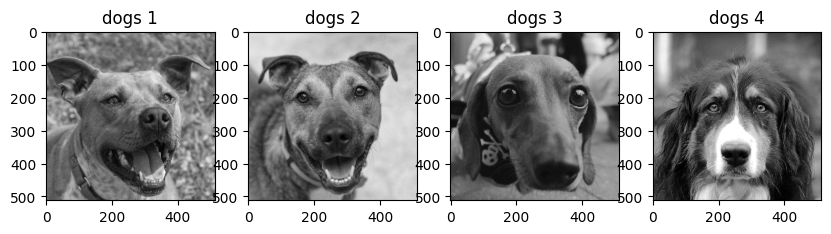

cats examples:


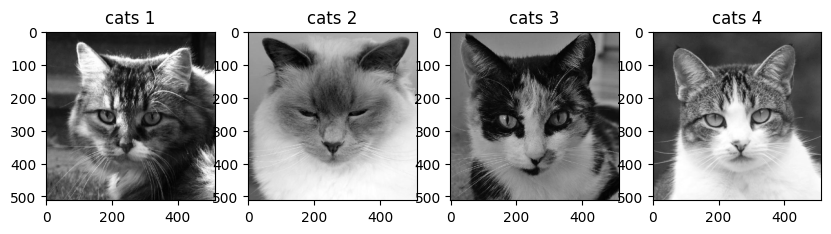

In [3]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import importlib

images_directory = "./images/train"
image_categories = ["dogs", "cats"]
n_examples = 4


def load_images_from_category(category):
    gray_images = [
        rgb2gray(img)
        for img in ski.io.imread_collection(images_directory + f"/{category}/*.jpg")
    ]
    gray_images_uint8 = [ski.util.img_as_ubyte(img) for img in gray_images]
    return gray_images_uint8


def load_train_images(categories):
    return {category: load_images_from_category(category) for category in categories}


train_images_by_categories = load_train_images(image_categories)

train_images_dogs = train_images_by_categories["dogs"]
train_images_cats = train_images_by_categories["cats"]


def show_gray_scale_image_examples(images, n=3, label="Example"):
    imgs = images[0:n]
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(imgs):
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap=plt.cm.gray)
        plt.title(f"{label} {i+1}")
        plt.axis("on")


def show_examples_by_category(categories, images, n=3):
    for category in categories:
        print(f"{category} examples:")
        show_gray_scale_image_examples(images[category], n=n, label=category)
        plt.show()

show_examples_by_category(image_categories, train_images_by_categories, n=n_examples)


Mostra o histograma das imagens de exemplo:

dogs histograms:


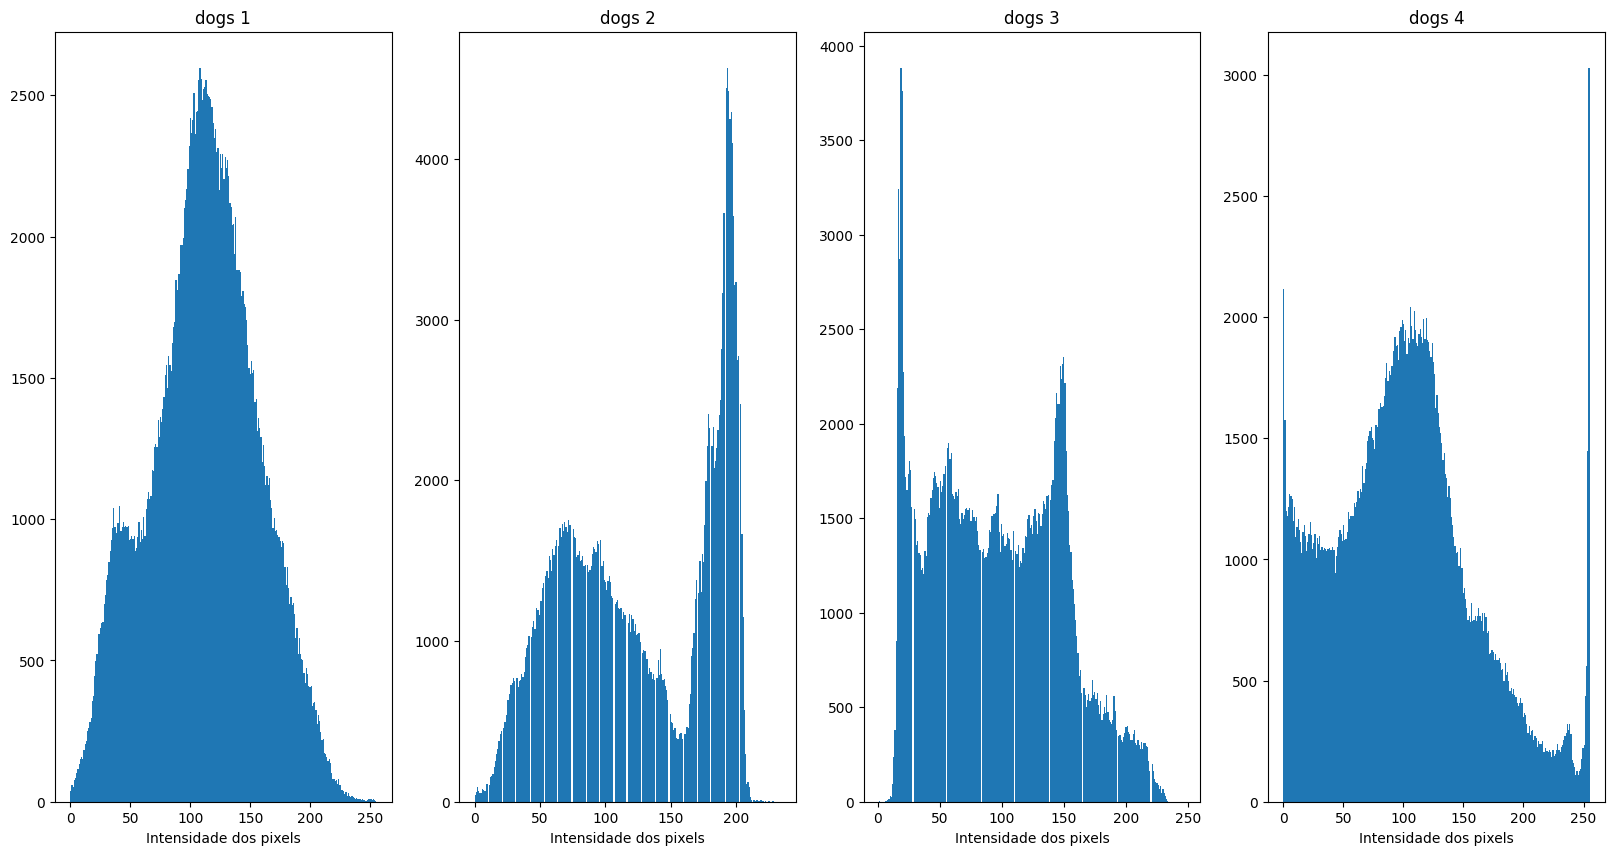

cats histograms:


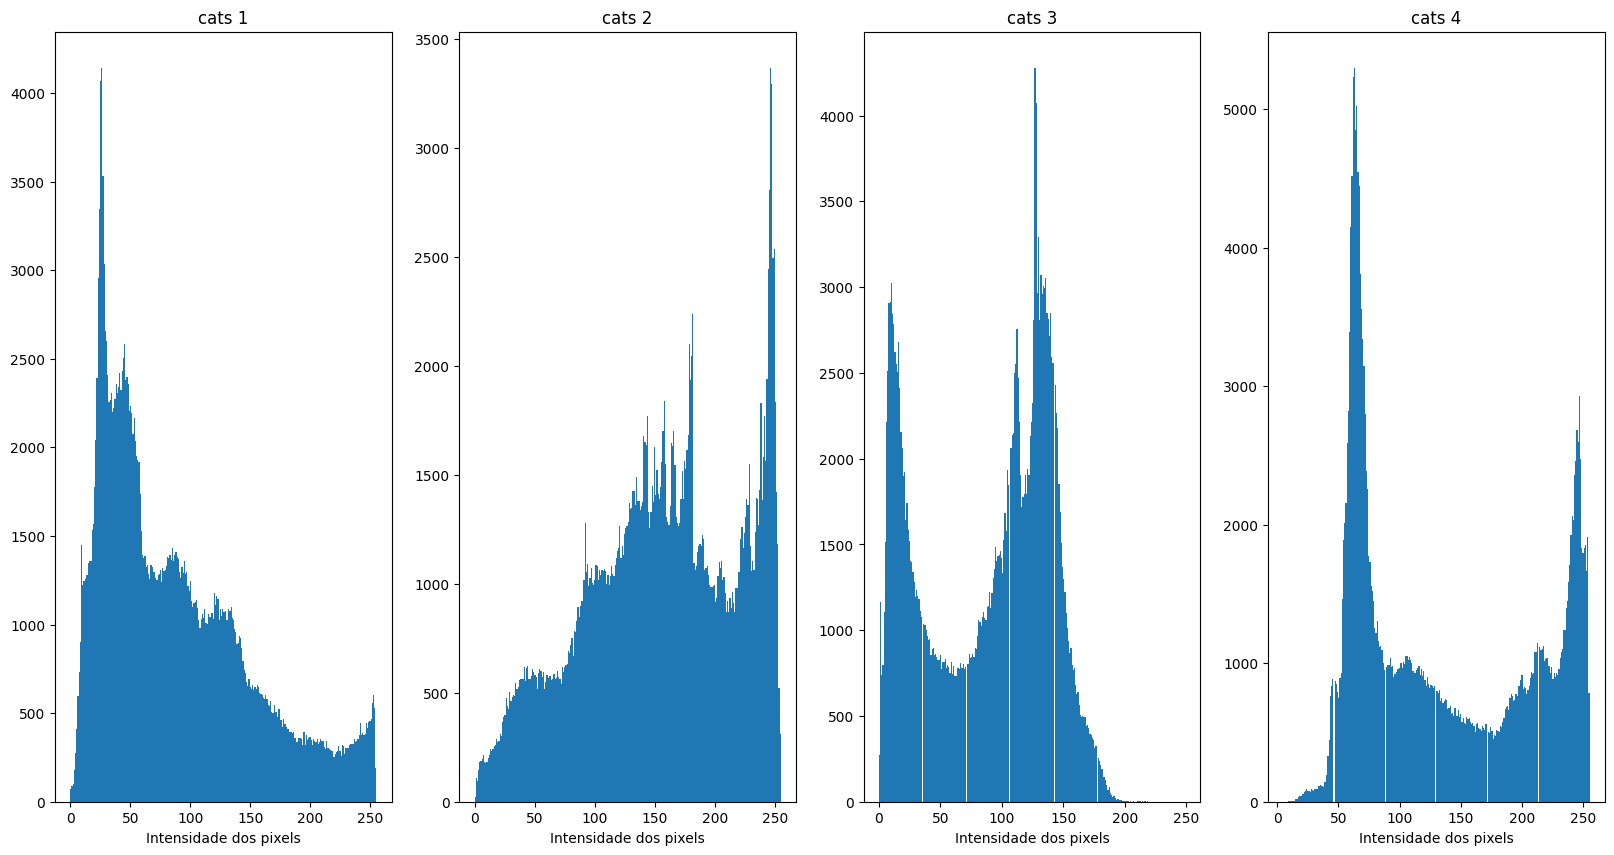

In [4]:
def show_examples_histograms(images, n=3, label="Example"):
    imgs = images[0:n]
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(imgs):
        plt.subplot(1, n, i + 1)
        plt.hist(img.ravel(), bins=256)
        plt.title(f"{label} {i+1}")
        plt.axis("on")
        plt.xlabel("Intensidade dos pixels")


def show_examples_histograms_by_category(categories, images, n=3):
    for category in categories:
        print(f"{category} histograms:")
        show_examples_histograms(images[category], n=n, label=category)
        plt.show()


show_examples_histograms_by_category(
    image_categories, train_images_by_categories, n=n_examples
)

## Ler features já processadas anteriormente

In [5]:
import files
from files import load_features_from_files, save_features_to_files, verify_features_files

importlib.reload(files)

<module 'files' from '/home/afmireski/Documentos/github/ai/images_classificator/files.py'>

In [6]:

features = []
FEATURES_FILES = ['lbp.npy', 'glcm.npy', 'lpq.npy', 'labels.npy']


# Verifica se alguma feature não está escrita em disco
all_features_stored = verify_features_files(FEATURES_FILES)
all_features_stored

True

## Extrair a estrutura das imagens de treino com LBP

Cada imagem tem sua própria estrutura. Todavia, imagens de objetos similares, via de regra, terão certa semelhança entre suas estruturas. Imagens de gatos terão uma "textura" similar entre si, supostamente. O que não é esperado ocorrer entre uma imagem de um gato e um cachorro, por exemplo.  

Nesse contexto, é possível utilizar o algoritmo **LBP (Local Binary Pattern)** para extrair a estrutura/textura das imagens de treino e agrupá-las em categorias.

Para visualizar a estrutura computada das imagens pode-se montar um histograma com as informações fornececidas pelo LBP.

In [7]:
import lbp
from lbp import compute_lbp_for_each_category, build_histograms_from_categories

importlib.reload(lbp)

def show_sample_histograms(histograms, n=3, label="Example"):
    vals = range(len(histograms[0]))
    plt.figure(figsize=(10, 5))

    for i, sample in enumerate(histograms[0:n]):
        plt.subplot(1, n, i + 1)
        plt.bar(vals, sample)
        plt.title(f"{label} {i+1}")
        plt.axis("on")


def show_sample_histograms_by_category(categories, lbps_dict_histograms, n=3):
    for category in categories:
        print(f'Identified {lbps_dict_histograms[category][0].shape[0]} characteristics for {category}')
        print(f"{category} histograms:")
        show_sample_histograms(lbps_dict_histograms[category], n=n, label=category)
        plt.show()

if not all_features_stored:

    # settings for LBP
    radius = 2
    n_pixels = 8

    lbps_dict_categories = compute_lbp_for_each_category(image_categories, train_images_by_categories, radius, n_pixels)

    lbps_histograms_by_categories = build_histograms_from_categories(
        image_categories, lbps_dict_categories, n_pixels
    )

    show_sample_histograms_by_category(
        image_categories, lbps_histograms_by_categories, n=n_examples
    )

    features.append(lbps_histograms_by_categories)
    

## Extrair características utilizando o GLCM

Outro algoritmo muito bom para extrair características de imagens em escala de cinza é o GLCM (Gray-Level Co-Ocurrence Matrix).  
Esse algoritmo conta com algumas técnicas de extração de texturas, que podem ser utilizadas para extrair características da imagem. Algumas delas são: Contraste, Correlação, Energia e Homogeneidade. 


### Calcular matriz GLCM

O primeiro passo do algoritmo GLCM é montar a matriz de níveis de cinza, onde o número de linhas e colunas é igual ao número de níveis de cinza.

In [8]:
import glcm

from glcm import calculate_glcm_matrix_for_each_category, extract_glcm_features_for_each_category, parallel_extract_glcm_features_for_each_category, parallel_calculate_glcm_matrix_for_each_category

importlib.reload(glcm)


<module 'glcm' from '/home/afmireski/Documentos/github/ai/images_classificator/glcm.py'>

In [9]:

GLCM_DISTANCES = [1, 3, 5]
GLCM_ANGLES = np.deg2rad([0, 90, 180, 270])
GLCM_LEVELS = None

if not all_features_stored:
    glcms_by_category = parallel_calculate_glcm_matrix_for_each_category(
        image_categories, train_images_by_categories, GLCM_DISTANCES, GLCM_ANGLES, GLCM_LEVELS
    )


### Extrair texturas das matrizes

Após computar as matrizes de nível de cinza, o próximo passo é extrair as características/texturas dessas matrizes, utilizando algumas das técnicas disponíveis: "contrast",    "dissimilarity", "homogeneity", "ASM","energy","correlation".

In [10]:
GLCM_FEATURES = [
    "contrast",
    "dissimilarity",
    "homogeneity",
    "ASM",
    "energy",
    "correlation",
]
if not all_features_stored:
    glcm_features_by_category = parallel_extract_glcm_features_for_each_category(
        image_categories, glcms_by_category, GLCM_FEATURES, 6
    )

    features.append(glcm_features_by_category)

Em média são extraídas 72 características de cada imagem, utilizando a configuração escolhida aqui.

Abaixo serão exibidas as características da primeira imagem de cada classe de treino para comparação:

In [11]:
def show_glcm_features_for_each_category(categories, glcms):
    for category in categories:
        glcm = glcms[category][0]

        plt.figure(figsize=(10, 5))
        plt.plot(glcm)
        plt.title(f"{category}[0] GLCM Features")
        plt.xlabel("Feature")
        plt.ylabel("Value")
    plt.show()

if not all_features_stored:
    show_glcm_features_for_each_category(image_categories, features[1])

## Extrair características utilizando LPQ

In [12]:
import lpq
from lpq import extract_lpq_features_for_each_category
importlib.reload(lpq)

<module 'lpq' from '/home/afmireski/Documentos/github/ai/images_classificator/lpq.py'>

In [13]:
if not all_features_stored:
    lpq_features_dict = extract_lpq_features_for_each_category(image_categories, train_images_by_categories)

    features.append(lpq_features_dict)

# Matriz de Características

Dicionários são pouco práticos para se armazenar informações que serão utilizadas para treinar modelos de Aprendizado de Máquina. Nesse contexto, vetores e matrizes são muito mais amplamente utilizados. 
Assim, dado um vetor de `N` rótulos, por exemplo, `images_categories`, é possível imaginar a seguinte estrutura:
- Um vetor de `N` posições: `images`.
    - Cada posição do vetor corresponde ao rótulo na mesma posição em `images_categories`.
- Cada posição contém um array de duas posições:
    - A primeira posição contém as matriz de características extraídas usando o `LBP`
    - A segunda posição contém a matriz de características extraídas usando o `GLCM`
    - A terceira posição contém um vetor de rótulos.
- Cada coluna da matriz é uma característica.
- Cada linha da matriz corresponde a uma imagem.


In [14]:
def obtain_features_matrix_from_category(label, dictionary):
    matrix = dictionary[label]
    return np.array(matrix)

def generate_images_data(labels, lbp_dict, glcm_dict, lpq_dict):
    data = []
    for l, label in enumerate(labels):
        lbp_matrix = obtain_features_matrix_from_category(label, lbp_dict)
        glcm_matrix = obtain_features_matrix_from_category(label, glcm_dict)
        lpq_matrix = obtain_features_matrix_from_category(label, lpq_dict)

        (n, _) = lbp_matrix.shape
        rotulos = [l] * n;
        data.append([lbp_matrix, glcm_matrix, lpq_matrix, rotulos])
    return data

data = []

if not all_features_stored:
    data = generate_images_data(image_categories, features[0], features[1], features[2])

Ao final do processo, é esperado que para cada imagem sejam identificadas 59 características utilizando o LBP, 72 utilizando o GLCM e 256 utilizando o LPQ.
Uma função que quantifica e resume as informações das imagens de entrada existe abaixo.

In [15]:
def show_data_resume(data):
    print("===Resumo dos Dados===")
    print(f"Foram lidas {len(data)} categorias:")
    for i, [lbp, glcm, lpq, _] in enumerate(data):
        print(f"Para a categoria {image_categories[i]}:")
        
        (lcount, lfeatures) = lbp.shape

        print(f"  - LBP: {lcount} exemplos com {lfeatures} características cada.")

        (gcount, gfeatures) = glcm.shape
        print(f"  - GLCM: {gcount} exemplos com {gfeatures} características cada.")

        (lpqcount, lpqfeatures) = lpq.shape
        print(f"  - LPQ: {lpqcount} exemplos com {lpqfeatures} características cada.")
    print("=======================")

if not all_features_stored:
    show_data_resume(data)
else:
    print("Features já foram carregadas do disco.")

Features já foram carregadas do disco.


Inicialmente, é interessante realizar o treino com todas as imagens juntas, sem separar por categoria. 
Nesse contexto será gerada a seguinte estrutura:
- Um vetor de 3 posições.
    - **Primeira posição:** Matriz de características LBP para todas as imagens
    - **Segunda posição:** Matriz de características GLCM para todas as imagens
    - **Terceira posição:** Matriz de características LPQ para todas as imagens
    - **Quarta posição:** Rótulos referentes a cada imagem.

In [16]:
def merge_data(data):
    # Extrai as matrizes e labels da primeira categoria
    [merge_lbp, merge_glcm, merge_lpq, merge_labels] = data[0]

    # Mescla os dados das demais categorias
    for [lbp, glcm, lqp, labels] in data[1:]:
        merge_lbp = np.vstack((merge_lbp, lbp))
        merge_glcm = np.vstack((merge_glcm, glcm))
        merge_lpq = np.vstack((merge_lpq, lqp))
        merge_labels = np.concatenate((merge_labels, labels))

    return [merge_lbp, merge_glcm, merge_lpq, merge_labels]

def show_features(data):
    [lbp, glcm, lpq, labels] = data

    print("===Resumo das Features===")
    (n,) = labels.shape
    print(f"Foram lidas {n} imagens:")
    (lcount, lfeatures) = lbp.shape

    print(f"  - LBP: {lcount} exemplos com {lfeatures} características cada.")

    (gcount, gfeatures) = glcm.shape
    print(f"  - GLCM: {gcount} exemplos com {gfeatures} características cada.")

    (lpqcount, lpqfeatures) = lpq.shape
    print(f"  - LPQ: {lpqcount} exemplos com {lpqfeatures} características cada.")
    print("=======================")

if not all_features_stored:
    features = merge_data(data)
    save_features_to_files(features, FEATURES_FILES)
else:
    features = load_features_from_files(FEATURES_FILES)
show_features(features)

===Resumo das Features===
Foram lidas 800 imagens:
  - LBP: 800 exemplos com 59 características cada.
  - GLCM: 800 exemplos com 72 características cada.
  - LPQ: 800 exemplos com 256 características cada.


# Dividir o conjunto de dados

Para esse projeto, será utilizada a técnica de validação cruzada em K-Partições, visando obter uma ideia melhor do desempenho do modelo, treinando-o com todos os dados.
Após alguns testes, foi escolhido `K=x`.

A ideia, é que hajam vários modelos, cada um treinado com um tipo de conjunto de dados:
- LBP
- GLCM
- LPQ
- LBP + GLCM
- LBP + LPQ
- GLCM + LPQ
- LBP + GLCM + LBP

Para facilitar o armazenamento, cada conjunto será um vetor com as seguintes características:
- Primeira posição será o conjunto total das features.
- Segunda posição será os rótulos


In [17]:
# Importa bilbliotecas que serão necessárias para dividir e padronizar dos dados
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Número de folds para a validação cruzada
K_FOLDS = 5 

In [18]:
# Extraí os conjuntos e os labels da estrutura de dados:
[X_lbp, X_glcm, X_lpq, y] = features
X_lbp_glcm = np.hstack((X_lbp, X_glcm)) # Merge das duas características
X_lbp_lpq = np.hstack((X_lbp, X_lpq)) # Merge das duas características
X_glcm_lpq = np.hstack((X_glcm, X_lpq)) # Merge das duas características
X_lbp_glcm_lpq = np.hstack((X_lbp, X_glcm, X_lpq)) # Merge das três características

print(f"X_lbp: {X_lbp.shape}")
print(f"X_glcm: {X_glcm.shape}")
print(f"X_lpq: {X_lpq.shape}")
print(f"X_lbp_glcm: {X_lbp_glcm.shape}")
print(f"X_lbp_lpq: {X_lbp_lpq.shape}")
print(f"X_glcm_lpq: {X_glcm_lpq.shape}")
print(f"X_lbp_glcm_lpq: {X_lbp_glcm_lpq.shape}")

def split_data(X, y, test_size=0.2, validation_size=0.2):
    # Divide dos dados em conjunto de treino e teste
    RAND_STATE_1 = 99 # Garante que a divisão seja sempre a mesma
    RAND_STATE_2 = 101 # Garante que a divisão seja sempre a mesma

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RAND_STATE_1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state=RAND_STATE_2)

    # Padronizar a escala
    ss = StandardScaler()

    # Calcula as estatísticas para a padronização com base nos dados de treinamento
    X_train = ss.fit_transform(X_train)

    # Aplicar a padronização para os demais conjuntos
    X_val = ss.transform(X_val)
    X_test = ss.transform(X_test)

    train = (X_train, y_train)
    val = (X_val, y_val)
    test = (X_test, y_test)
    return [train, val, test]
    
set_lbp = [X_lbp, y]
set_glcm = [X_glcm, y]
set_lpq = [X_lpq, y]
set_lbp_glcm = [X_lbp_glcm, y]
set_lbp_lpq = [X_lbp_lpq, y]
set_glcm_lpq = [X_glcm_lpq, y]
set_lbp_glcm_lpq = [X_lbp_glcm_lpq, y]

X_lbp: (800, 59)
X_glcm: (800, 72)
X_lpq: (800, 256)
X_lbp_glcm: (800, 131)
X_lbp_lpq: (800, 315)
X_glcm_lpq: (800, 328)
X_lbp_glcm_lpq: (800, 387)


# Modelo KNN

Um dos algoritmos supervisionados mais simples é o KNN (K-Nearest Neighbor), K Vizinhos mais Próximos em tradução livre.
Ele parte da ideia de que dados que pertencem a um mesmo conjunto estarão próximos entre si, então, é seguro presumir que um novo dado pertencerá ao conjunto com mais elementos similares na região.  
Basicamente é o ditado: `"Diga-me com quem andas e te direi quem és."`.  

Partindo para uma explicação mais técnica, o `k` é um raio que define a zona de busca a ser considerada em torno do novo elemento.  
Dado esse novo elemento, será computada a distância entre o novo registro e cada ponto do conjunto, registrando-as num vetor de distância e relacionando-as com o label correspondente.
Depois, esse vetor será ordenado, tendo com base as distâncias. Indo dos mais próximos para os mais distantes.
Após a ordenação, será utilizado valor de `k` para selecionar os `k` primeiros elementos do vetor, fazendo o cálculo de frequência para cada categoria.
A categoria com maior frequência será a escolhida como categoria do novo elemento.

## Sobre o valor de K
- Se `k` for muito pequeno (`k=1`), a classificação pode ser sensível a ruídos.
- Se `k` for muito grande, podem ser incluídos elementos de outras classes.
- `k` ímpares garantem que não haverá empates.

## Sobre o cálculo de distâncias
É possível mudar a fórmula do cálculo da distância, pois dependendo do conjunto de dados, certas fórmulas se saem melhores do que outras. Alguns exemplos:
- Euclidiana
- Manhattan
- City Block



In [19]:
# Importa as bibliotecas do KNN
from sklearn.neighbors import KNeighborsClassifier

# Bibliotecas úteis para treinamento dos modelos
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline


import utils
from utils import show_predict_infos
importlib.reload(utils)

<module 'utils' from '/home/afmireski/Documentos/github/ai/images_classificator/utils.py'>

Uma boa predição depende dos parâmetros utilizados, nesse sentido, é desejado utilizar sempre os melhores parâmetros para se obter o melhor resultado possível. É para descobrir quais são esses parâmetros que serve o conjunto de validação.

In [20]:
K_ARRAY = [1, 3, 5, 7, 9]
DISTANCE_METRICS = ["euclidean", "manhattan", "minkowski"]

def tune_knn(k_array, distance_metrics):

    knn = KNeighborsClassifier()

    # Lista com as combinações de hiperparâmetros
    parameters = {
        "knn__n_neighbors": k_array,
        "knn__metric": distance_metrics
    }

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", knn)
    ])

    model = GridSearchCV(pipe, parameters, n_jobs=-1)


    return model

print("Tunando parâmetros do KNN...")
base_knn = tune_knn(K_ARRAY, DISTANCE_METRICS)

Tunando parâmetros do KNN...


=== Modelos KNN ===
Classificação do modelo LBP:


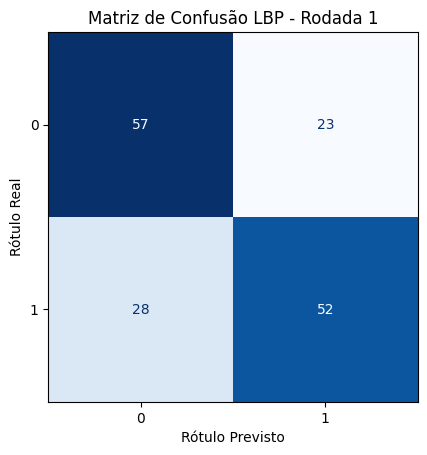

A acurácia no conjunto de testes: 68.12%
A recall no conjunto de testes: 68.12%
A precision no conjunto de testes: 68.20%
A F1 no conjunto de testes: 68.09%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        80
           1       0.69      0.65      0.67        80

    accuracy                           0.68       160
   macro avg       0.68      0.68      0.68       160
weighted avg       0.68      0.68      0.68       160



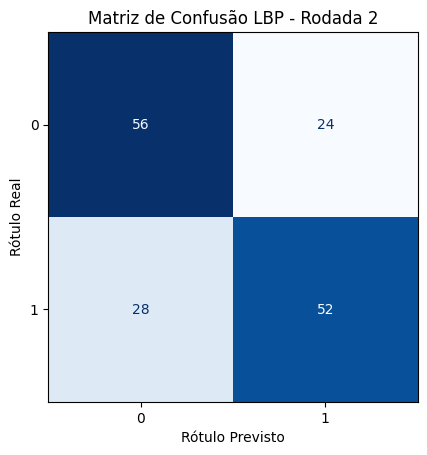

A acurácia no conjunto de testes: 67.50%
A recall no conjunto de testes: 67.50%
A precision no conjunto de testes: 67.54%
A F1 no conjunto de testes: 67.48%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.67      0.70      0.68        80
           1       0.68      0.65      0.67        80

    accuracy                           0.68       160
   macro avg       0.68      0.68      0.67       160
weighted avg       0.68      0.68      0.67       160



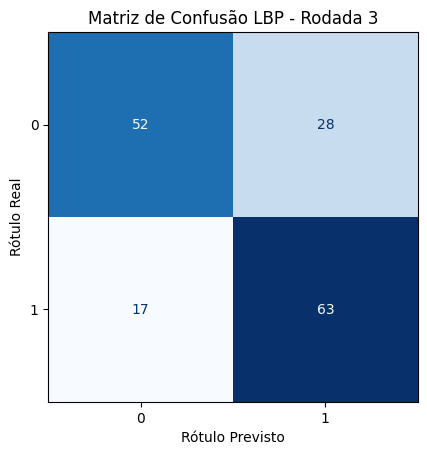

A acurácia no conjunto de testes: 71.88%
A recall no conjunto de testes: 71.88%
A precision no conjunto de testes: 72.30%
A F1 no conjunto de testes: 71.74%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.75      0.65      0.70        80
           1       0.69      0.79      0.74        80

    accuracy                           0.72       160
   macro avg       0.72      0.72      0.72       160
weighted avg       0.72      0.72      0.72       160



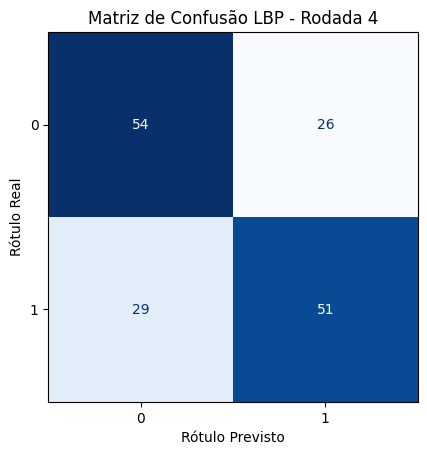

A acurácia no conjunto de testes: 65.62%
A recall no conjunto de testes: 65.62%
A precision no conjunto de testes: 65.65%
A F1 no conjunto de testes: 65.61%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.65      0.68      0.66        80
           1       0.66      0.64      0.65        80

    accuracy                           0.66       160
   macro avg       0.66      0.66      0.66       160
weighted avg       0.66      0.66      0.66       160



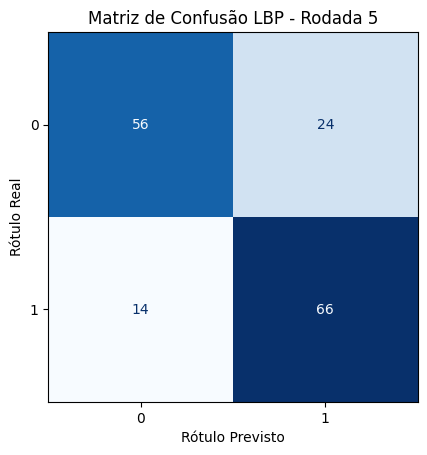

A acurácia no conjunto de testes: 76.25%
A recall no conjunto de testes: 76.25%
A precision no conjunto de testes: 76.67%
A F1 no conjunto de testes: 76.16%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.80      0.70      0.75        80
           1       0.73      0.82      0.78        80

    accuracy                           0.76       160
   macro avg       0.77      0.76      0.76       160
weighted avg       0.77      0.76      0.76       160

Avaliação média do modelo LBP:
Acurácia: 0.70 +- 0.04
F1: 0.70 +- 0.04
Recall: 0.70 +- 0.04
Precisão: 0.70 +- 0.04


Classificação do modelo GLCM:


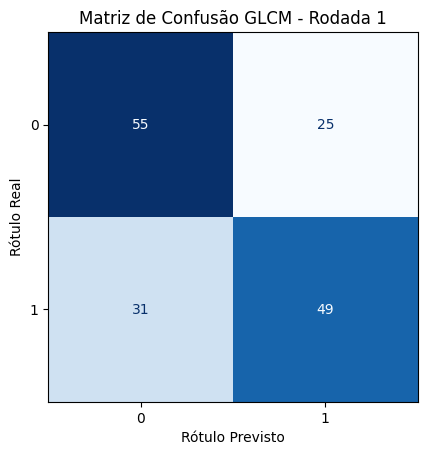

A acurácia no conjunto de testes: 65.00%
A recall no conjunto de testes: 65.00%
A precision no conjunto de testes: 65.08%
A F1 no conjunto de testes: 64.95%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.64      0.69      0.66        80
           1       0.66      0.61      0.64        80

    accuracy                           0.65       160
   macro avg       0.65      0.65      0.65       160
weighted avg       0.65      0.65      0.65       160



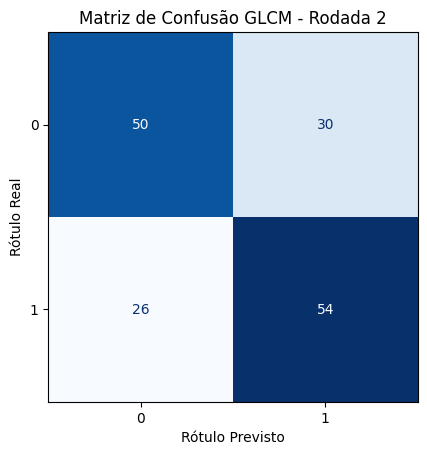

A acurácia no conjunto de testes: 65.00%
A recall no conjunto de testes: 65.00%
A precision no conjunto de testes: 65.04%
A F1 no conjunto de testes: 64.98%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.66      0.62      0.64        80
           1       0.64      0.68      0.66        80

    accuracy                           0.65       160
   macro avg       0.65      0.65      0.65       160
weighted avg       0.65      0.65      0.65       160



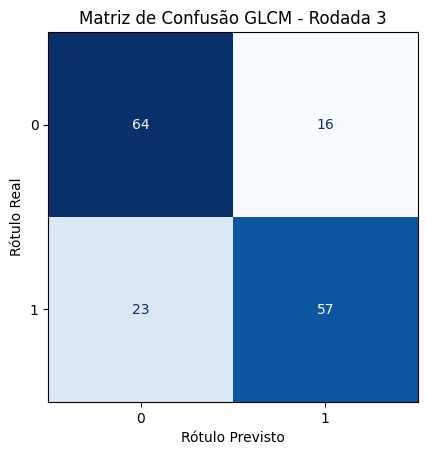

A acurácia no conjunto de testes: 75.62%
A recall no conjunto de testes: 75.63%
A precision no conjunto de testes: 75.82%
A F1 no conjunto de testes: 75.58%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.74      0.80      0.77        80
           1       0.78      0.71      0.75        80

    accuracy                           0.76       160
   macro avg       0.76      0.76      0.76       160
weighted avg       0.76      0.76      0.76       160



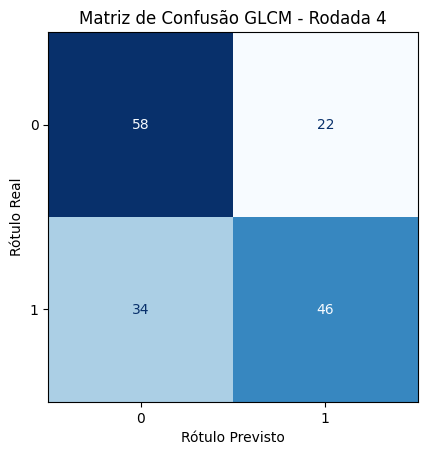

A acurácia no conjunto de testes: 65.00%
A recall no conjunto de testes: 65.00%
A precision no conjunto de testes: 65.35%
A F1 no conjunto de testes: 64.80%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.63      0.72      0.67        80
           1       0.68      0.57      0.62        80

    accuracy                           0.65       160
   macro avg       0.65      0.65      0.65       160
weighted avg       0.65      0.65      0.65       160



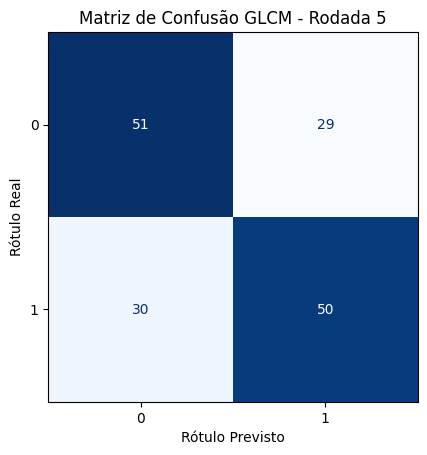

A acurácia no conjunto de testes: 63.12%
A recall no conjunto de testes: 63.12%
A precision no conjunto de testes: 63.13%
A F1 no conjunto de testes: 63.12%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.63      0.64      0.63        80
           1       0.63      0.62      0.63        80

    accuracy                           0.63       160
   macro avg       0.63      0.63      0.63       160
weighted avg       0.63      0.63      0.63       160

Avaliação média do modelo GLCM:
Acurácia: 0.67 +- 0.04
F1: 0.67 +- 0.04
Recall: 0.67 +- 0.04
Precisão: 0.67 +- 0.05


Classificação do modelo LPQ:


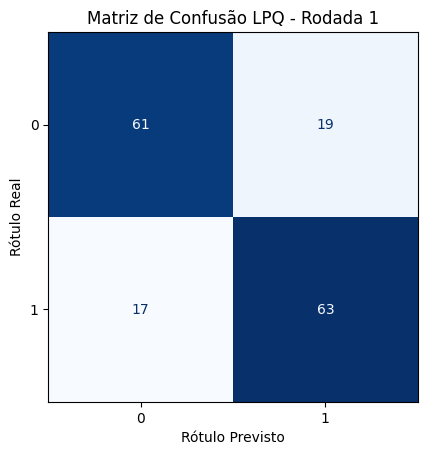

A acurácia no conjunto de testes: 77.50%
A recall no conjunto de testes: 77.50%
A precision no conjunto de testes: 77.52%
A F1 no conjunto de testes: 77.50%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        80
           1       0.77      0.79      0.78        80

    accuracy                           0.78       160
   macro avg       0.78      0.77      0.77       160
weighted avg       0.78      0.78      0.77       160



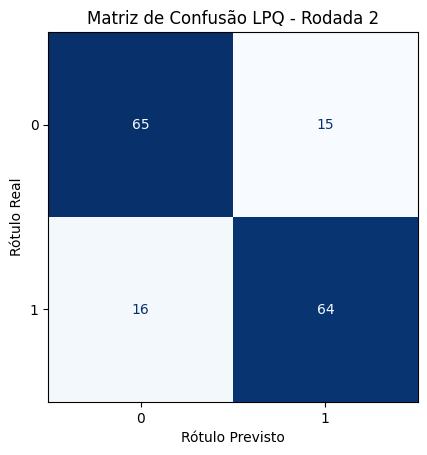

A acurácia no conjunto de testes: 80.62%
A recall no conjunto de testes: 80.62%
A precision no conjunto de testes: 80.63%
A F1 no conjunto de testes: 80.62%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.80      0.81      0.81        80
           1       0.81      0.80      0.81        80

    accuracy                           0.81       160
   macro avg       0.81      0.81      0.81       160
weighted avg       0.81      0.81      0.81       160



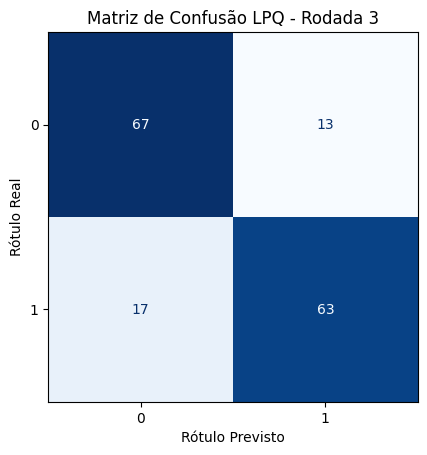

A acurácia no conjunto de testes: 81.25%
A recall no conjunto de testes: 81.25%
A precision no conjunto de testes: 81.33%
A F1 no conjunto de testes: 81.24%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        80
           1       0.83      0.79      0.81        80

    accuracy                           0.81       160
   macro avg       0.81      0.81      0.81       160
weighted avg       0.81      0.81      0.81       160



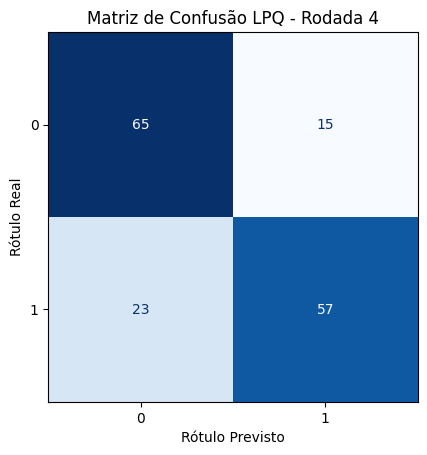

A acurácia no conjunto de testes: 76.25%
A recall no conjunto de testes: 76.25%
A precision no conjunto de testes: 76.52%
A F1 no conjunto de testes: 76.19%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.74      0.81      0.77        80
           1       0.79      0.71      0.75        80

    accuracy                           0.76       160
   macro avg       0.77      0.76      0.76       160
weighted avg       0.77      0.76      0.76       160



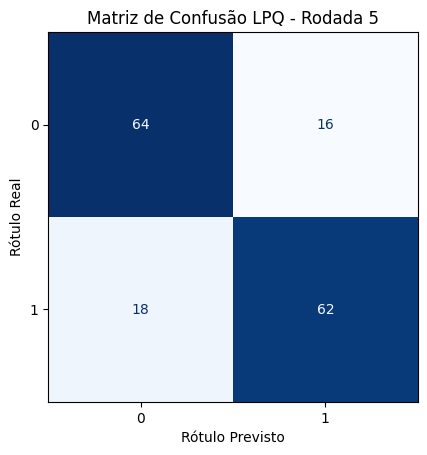

A acurácia no conjunto de testes: 78.75%
A recall no conjunto de testes: 78.75%
A precision no conjunto de testes: 78.77%
A F1 no conjunto de testes: 78.75%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.78      0.80      0.79        80
           1       0.79      0.78      0.78        80

    accuracy                           0.79       160
   macro avg       0.79      0.79      0.79       160
weighted avg       0.79      0.79      0.79       160

Avaliação média do modelo LPQ:
Acurácia: 0.79 +- 0.02
F1: 0.79 +- 0.02
Recall: 0.79 +- 0.02
Precisão: 0.79 +- 0.02


Classificação do modelo LBP+GLCM:


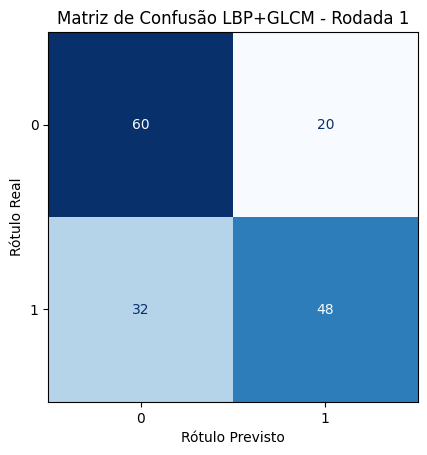

A acurácia no conjunto de testes: 67.50%
A recall no conjunto de testes: 67.50%
A precision no conjunto de testes: 67.90%
A F1 no conjunto de testes: 67.32%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.65      0.75      0.70        80
           1       0.71      0.60      0.65        80

    accuracy                           0.68       160
   macro avg       0.68      0.68      0.67       160
weighted avg       0.68      0.68      0.67       160



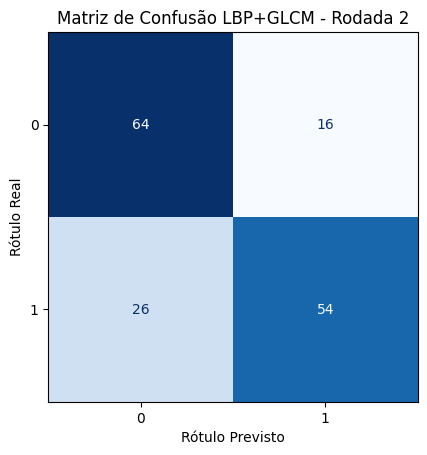

A acurácia no conjunto de testes: 73.75%
A recall no conjunto de testes: 73.75%
A precision no conjunto de testes: 74.13%
A F1 no conjunto de testes: 73.65%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        80
           1       0.77      0.68      0.72        80

    accuracy                           0.74       160
   macro avg       0.74      0.74      0.74       160
weighted avg       0.74      0.74      0.74       160



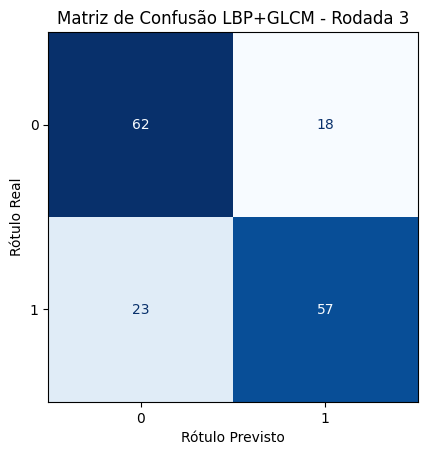

A acurácia no conjunto de testes: 74.38%
A recall no conjunto de testes: 74.38%
A precision no conjunto de testes: 74.47%
A F1 no conjunto de testes: 74.35%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.73      0.78      0.75        80
           1       0.76      0.71      0.74        80

    accuracy                           0.74       160
   macro avg       0.74      0.74      0.74       160
weighted avg       0.74      0.74      0.74       160



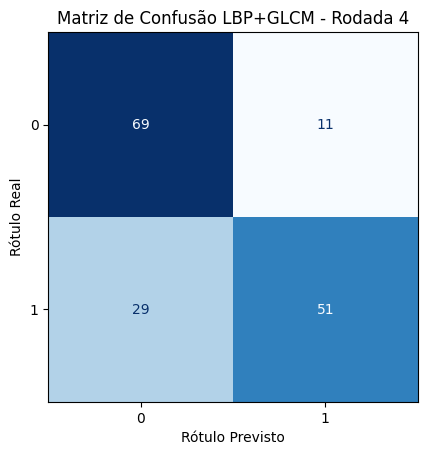

A acurácia no conjunto de testes: 75.00%
A recall no conjunto de testes: 75.00%
A precision no conjunto de testes: 76.33%
A F1 no conjunto de testes: 74.68%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.70      0.86      0.78        80
           1       0.82      0.64      0.72        80

    accuracy                           0.75       160
   macro avg       0.76      0.75      0.75       160
weighted avg       0.76      0.75      0.75       160



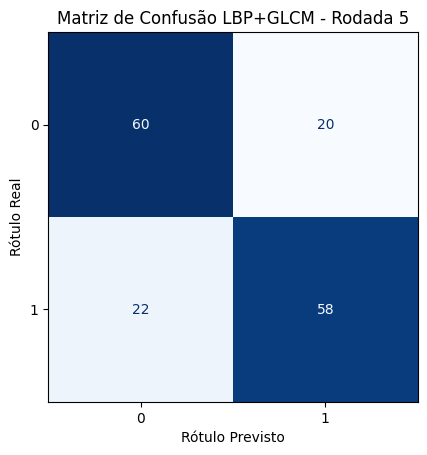

A acurácia no conjunto de testes: 73.75%
A recall no conjunto de testes: 73.75%
A precision no conjunto de testes: 73.76%
A F1 no conjunto de testes: 73.75%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.73      0.75      0.74        80
           1       0.74      0.72      0.73        80

    accuracy                           0.74       160
   macro avg       0.74      0.74      0.74       160
weighted avg       0.74      0.74      0.74       160

Avaliação média do modelo LBP+GLCM:
Acurácia: 0.73 +- 0.03
F1: 0.73 +- 0.03
Recall: 0.73 +- 0.03
Precisão: 0.73 +- 0.03


Classificação do modelo LBP+LPQ:


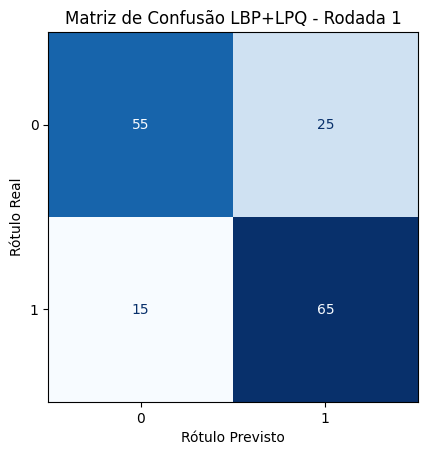

A acurácia no conjunto de testes: 75.00%
A recall no conjunto de testes: 75.00%
A precision no conjunto de testes: 75.40%
A F1 no conjunto de testes: 74.90%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.79      0.69      0.73        80
           1       0.72      0.81      0.76        80

    accuracy                           0.75       160
   macro avg       0.75      0.75      0.75       160
weighted avg       0.75      0.75      0.75       160



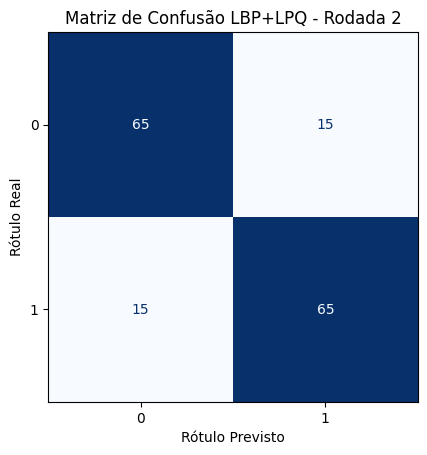

A acurácia no conjunto de testes: 81.25%
A recall no conjunto de testes: 81.25%
A precision no conjunto de testes: 81.25%
A F1 no conjunto de testes: 81.25%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        80
           1       0.81      0.81      0.81        80

    accuracy                           0.81       160
   macro avg       0.81      0.81      0.81       160
weighted avg       0.81      0.81      0.81       160



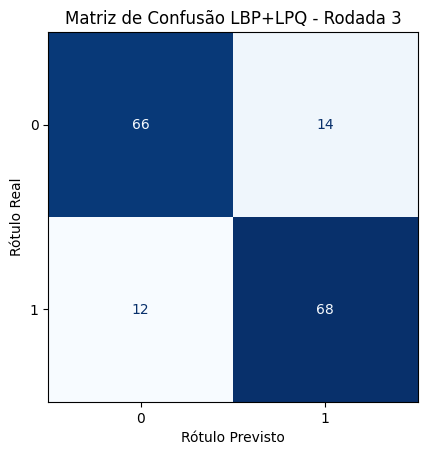

A acurácia no conjunto de testes: 83.75%
A recall no conjunto de testes: 83.75%
A precision no conjunto de testes: 83.77%
A F1 no conjunto de testes: 83.75%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.85      0.82      0.84        80
           1       0.83      0.85      0.84        80

    accuracy                           0.84       160
   macro avg       0.84      0.84      0.84       160
weighted avg       0.84      0.84      0.84       160



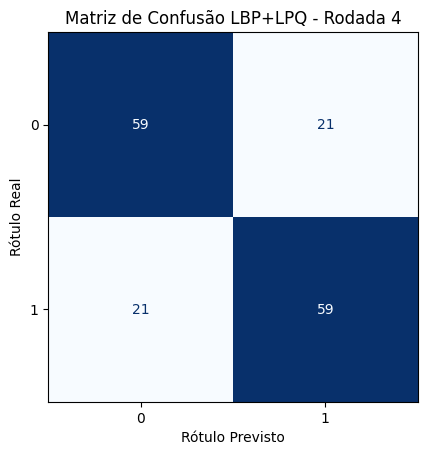

A acurácia no conjunto de testes: 73.75%
A recall no conjunto de testes: 73.75%
A precision no conjunto de testes: 73.75%
A F1 no conjunto de testes: 73.75%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.74      0.74      0.74        80
           1       0.74      0.74      0.74        80

    accuracy                           0.74       160
   macro avg       0.74      0.74      0.74       160
weighted avg       0.74      0.74      0.74       160



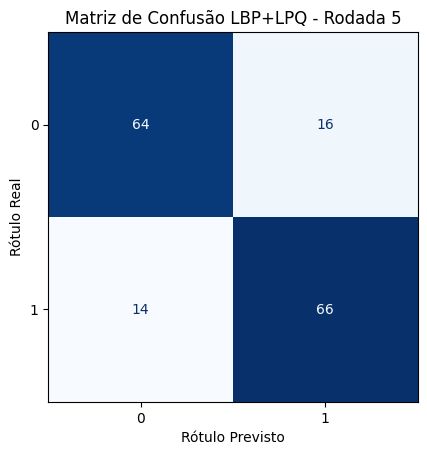

A acurácia no conjunto de testes: 81.25%
A recall no conjunto de testes: 81.25%
A precision no conjunto de testes: 81.27%
A F1 no conjunto de testes: 81.25%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.82      0.80      0.81        80
           1       0.80      0.82      0.81        80

    accuracy                           0.81       160
   macro avg       0.81      0.81      0.81       160
weighted avg       0.81      0.81      0.81       160

Avaliação média do modelo LBP+LPQ:
Acurácia: 0.79 +- 0.04
F1: 0.79 +- 0.04
Recall: 0.79 +- 0.04
Precisão: 0.79 +- 0.04


Classificação do modelo GLCM+LPQ:


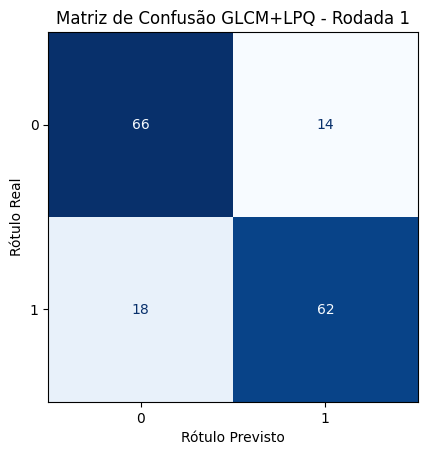

A acurácia no conjunto de testes: 80.00%
A recall no conjunto de testes: 80.00%
A precision no conjunto de testes: 80.08%
A F1 no conjunto de testes: 79.99%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.79      0.82      0.80        80
           1       0.82      0.78      0.79        80

    accuracy                           0.80       160
   macro avg       0.80      0.80      0.80       160
weighted avg       0.80      0.80      0.80       160



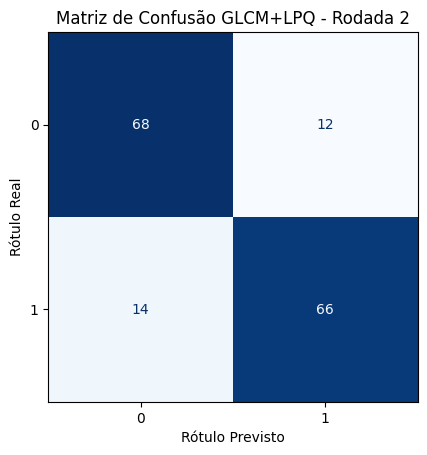

A acurácia no conjunto de testes: 83.75%
A recall no conjunto de testes: 83.75%
A precision no conjunto de testes: 83.77%
A F1 no conjunto de testes: 83.75%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        80
           1       0.85      0.82      0.84        80

    accuracy                           0.84       160
   macro avg       0.84      0.84      0.84       160
weighted avg       0.84      0.84      0.84       160



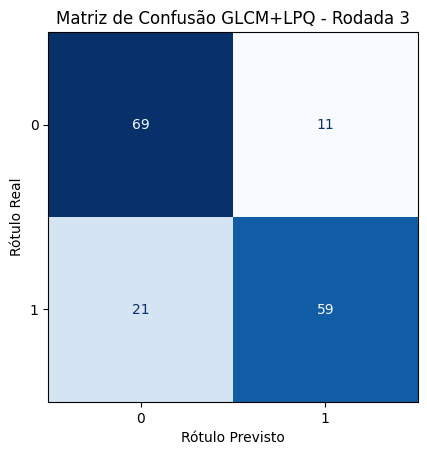

A acurácia no conjunto de testes: 80.00%
A recall no conjunto de testes: 80.00%
A precision no conjunto de testes: 80.48%
A F1 no conjunto de testes: 79.92%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.77      0.86      0.81        80
           1       0.84      0.74      0.79        80

    accuracy                           0.80       160
   macro avg       0.80      0.80      0.80       160
weighted avg       0.80      0.80      0.80       160



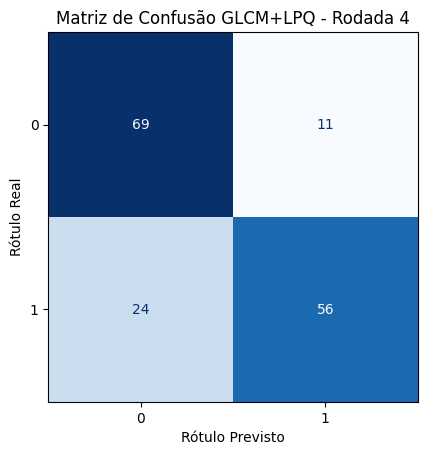

A acurácia no conjunto de testes: 78.12%
A recall no conjunto de testes: 78.12%
A precision no conjunto de testes: 78.89%
A F1 no conjunto de testes: 77.98%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.74      0.86      0.80        80
           1       0.84      0.70      0.76        80

    accuracy                           0.78       160
   macro avg       0.79      0.78      0.78       160
weighted avg       0.79      0.78      0.78       160



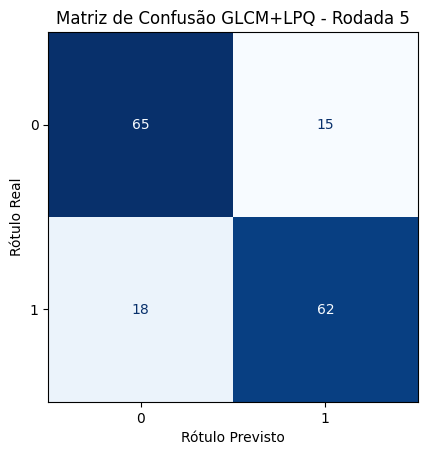

A acurácia no conjunto de testes: 79.38%
A recall no conjunto de testes: 79.38%
A precision no conjunto de testes: 79.42%
A F1 no conjunto de testes: 79.37%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.78      0.81      0.80        80
           1       0.81      0.78      0.79        80

    accuracy                           0.79       160
   macro avg       0.79      0.79      0.79       160
weighted avg       0.79      0.79      0.79       160

Avaliação média do modelo GLCM+LPQ:
Acurácia: 0.80 +- 0.02
F1: 0.80 +- 0.02
Recall: 0.80 +- 0.02
Precisão: 0.81 +- 0.02


Classificação do modelo LBP+GLCM+LPQ:


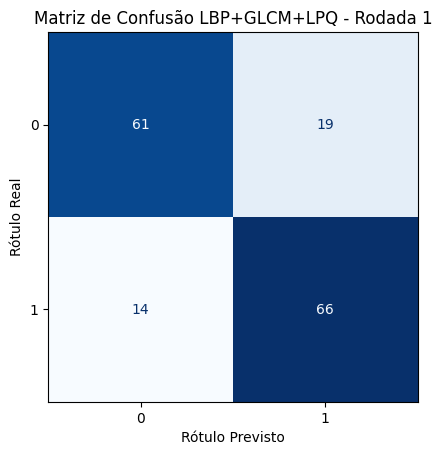

A acurácia no conjunto de testes: 79.38%
A recall no conjunto de testes: 79.38%
A precision no conjunto de testes: 79.49%
A F1 no conjunto de testes: 79.35%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.81      0.76      0.79        80
           1       0.78      0.82      0.80        80

    accuracy                           0.79       160
   macro avg       0.79      0.79      0.79       160
weighted avg       0.79      0.79      0.79       160



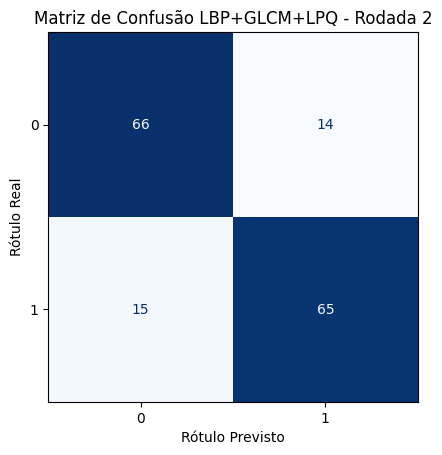

A acurácia no conjunto de testes: 81.88%
A recall no conjunto de testes: 81.88%
A precision no conjunto de testes: 81.88%
A F1 no conjunto de testes: 81.87%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.81      0.82      0.82        80
           1       0.82      0.81      0.82        80

    accuracy                           0.82       160
   macro avg       0.82      0.82      0.82       160
weighted avg       0.82      0.82      0.82       160



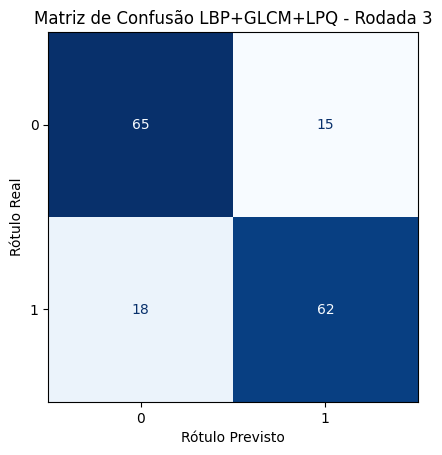

A acurácia no conjunto de testes: 79.38%
A recall no conjunto de testes: 79.38%
A precision no conjunto de testes: 79.42%
A F1 no conjunto de testes: 79.37%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.78      0.81      0.80        80
           1       0.81      0.78      0.79        80

    accuracy                           0.79       160
   macro avg       0.79      0.79      0.79       160
weighted avg       0.79      0.79      0.79       160



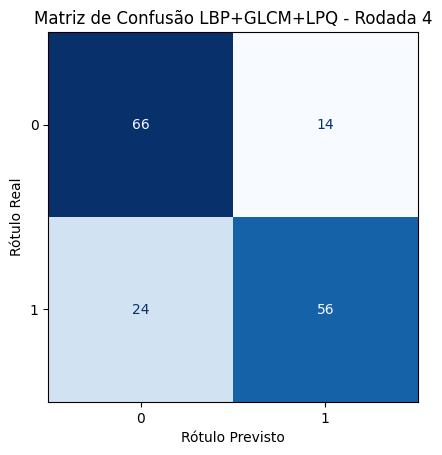

A acurácia no conjunto de testes: 76.25%
A recall no conjunto de testes: 76.25%
A precision no conjunto de testes: 76.67%
A F1 no conjunto de testes: 76.16%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.73      0.82      0.78        80
           1       0.80      0.70      0.75        80

    accuracy                           0.76       160
   macro avg       0.77      0.76      0.76       160
weighted avg       0.77      0.76      0.76       160



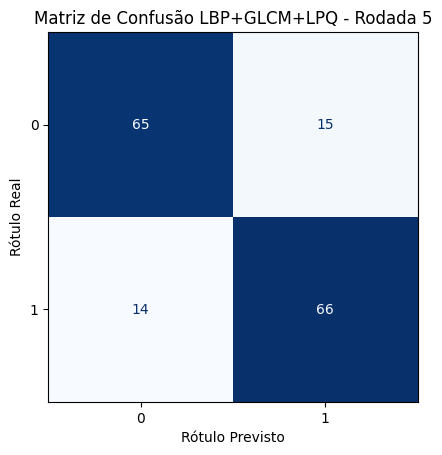

A acurácia no conjunto de testes: 81.88%
A recall no conjunto de testes: 81.88%
A precision no conjunto de testes: 81.88%
A F1 no conjunto de testes: 81.87%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.82      0.81      0.82        80
           1       0.81      0.82      0.82        80

    accuracy                           0.82       160
   macro avg       0.82      0.82      0.82       160
weighted avg       0.82      0.82      0.82       160

Avaliação média do modelo LBP+GLCM+LPQ:
Acurácia: 0.80 +- 0.02
F1: 0.80 +- 0.02
Recall: 0.80 +- 0.02
Precisão: 0.80 +- 0.02


=== Melhor modelo KNN: GLCM+LPQ ===
Acurácia: 0.802 +- 0.019}
F1: 0.802 +- 0.019}
Recall: 0.802 +- 0.019}
Precisão: 0.805 +- 0.017}
<====================================>




In [23]:
# Classificando os modelos

best_knn = None

def predict_knn(knn, X, y, title=""):
    skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
    metrics = ([], [], [], [])
    rodada = 1
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        knn.fit(X_train, y_train)

        predict = knn.predict(X_test)

        accuracy, f1, recall, precision = show_predict_infos(y_test, predict, title=f"{title} - Rodada {rodada}")

        metrics[0].append(accuracy)
        metrics[1].append(f1)
        metrics[2].append(recall)
        metrics[3].append(precision)
                          
        rodada+=1


    mean_accuracy, std_accuracy = np.mean(metrics[0]), np.std(metrics[0])
    mean_f1, std_f1 = np.mean(metrics[1]), np.std(metrics[1])
    mean_recall, std_recall = np.mean(metrics[2]), np.std(metrics[2])
    mean_precision, std_precision = np.mean(metrics[3]), np.std(metrics[3])
    
    print(f"Avaliação média do modelo {title}:")
    print("Acurácia: %.2f +- %.2f" % (mean_accuracy, std_accuracy))
    print("F1: %.2f +- %.2f" % (mean_f1, std_f1))
    print("Recall: %.2f +- %.2f" % (mean_recall, std_recall))
    print("Precisão: %.2f +- %.2f" % (mean_precision, std_precision))
    print("====================================\n\n")

    global best_knn
    if best_knn is None or mean_f1 > best_knn[2][0]:
        best_knn = (title, (mean_accuracy, std_accuracy), (mean_f1, std_f1), (mean_recall, std_recall), (mean_precision, std_precision))

print("=== Modelos KNN ===")
print("Classificação do modelo LBP:")
predict_knn(base_knn, set_lbp[0], set_lbp[1], title="LBP")

print("Classificação do modelo GLCM:")
predict_knn(base_knn, set_glcm[0], set_glcm[1], title="GLCM")

print("Classificação do modelo LPQ:")
predict_knn(base_knn, set_lpq[0], set_lpq[1], title="LPQ")

print("Classificação do modelo LBP+GLCM:")
predict_knn(base_knn, set_lbp_glcm[0], set_lbp_glcm[1], title="LBP+GLCM")

print("Classificação do modelo LBP+LPQ:")
predict_knn(base_knn, set_lbp_lpq[0], set_lbp_lpq[1], title="LBP+LPQ")

print("Classificação do modelo GLCM+LPQ:")
predict_knn(base_knn, set_glcm_lpq[0], set_glcm_lpq[1], title="GLCM+LPQ")

print("Classificação do modelo LBP+GLCM+LPQ:")
predict_knn(base_knn, set_lbp_glcm_lpq[0], set_lbp_glcm_lpq[1], title="LBP+GLCM+LPQ")

print(f"=== Melhor modelo KNN: {best_knn[0]} ===")
print("Acurácia: %.3f +- %.3f}" % (best_knn[1][0], best_knn[1][1]))
print("F1: %.3f +- %.3f}" % (best_knn[2][0], best_knn[2][1]))
print("Recall: %.3f +- %.3f}" % (best_knn[3][0], best_knn[3][1]))
print("Precisão: %.3f +- %.3f}" % (best_knn[4][0], best_knn[4][1]))
print("<====================================>\n\n")

# Modelo Árvore de Decisão

Árvores de decisão são um conjunto de algoritmos supervisionados, sendo extremamente simples e possuindo uma boa taxa de sucesso.  
Seu funcionamento é simples, dada uma árvore, onde cada vértice é um teste de um atributo. Seguindo uma sequência desses testes internos, ao final, será retornada uma decisão.  
As decisões são os nós folhas da árvore.

## Parâmetros
### Sobre o criterion
### Sobre o max_depth
### Sobre o min_samples_split
### Sobre o min_samples_leaf

Da mesma forma que ocorreu com o KNN, utilizar os valores padrão não é uma boa ideia. É necessário otimizar os hiperparâmetros em busca da melhor configuração para treinar o modelo.

In [34]:
# Importa as bibliotecas da Árvore de Decisão
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

import utils
from utils import show_predict_infos
importlib.reload(utils)

<module 'utils' from '/home/afmireski/Documentos/github/ai/images_classificator/utils.py'>

In [35]:
# Hiperparâmetros da árvore de decisão:
MIN_SAMPLES_LEAFS = [3, 5, 10, 15, 20, 30]
MIN_SAMPLES_SPLITS = [2, 4, 8, 16, 32, 40]
MAX_DEPTHS = [None, 2, 3, 4, 5]
CRITERIONS = ["gini", "entropy", "log_loss"]

In [36]:
def tune_decision_tree(
    criterions,
    min_samples_leaf_array,
    min_samples_split_array,
    max_depth_array
):
    
    dt = DecisionTreeClassifier()

    # Lista com as combinações de hiperparâmetros
    parameters = {
        "dt__criterion": criterions,
        "dt__min_samples_leaf": min_samples_leaf_array,
        "dt__min_samples_split": min_samples_split_array,
        "dt__max_depth": max_depth_array,

    }

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("dt", dt)
    ])

    model = GridSearchCV(pipe, parameters, n_jobs=-1)


    return model

show_logs=False

print("Tunando parâmetros da Árvore de Decisão...")
base_dt = tune_decision_tree(
    CRITERIONS,
    MIN_SAMPLES_LEAFS,
    MIN_SAMPLES_SPLITS,
    MAX_DEPTHS
)

Tunando parâmetros da Árvore de Decisão...


Resultados Modelo Árvore de Decisão:
Classificação do conjunto LBP:


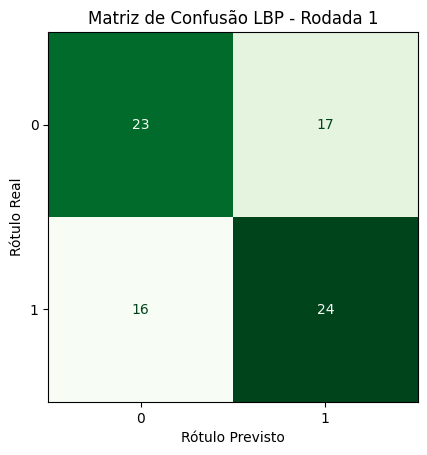

A acurácia no conjunto de testes: 58.75%
A recall no conjunto de testes: 58.75%
A precision no conjunto de testes: 58.76%
A F1 no conjunto de testes: 58.74%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.59      0.57      0.58        40
           1       0.59      0.60      0.59        40

    accuracy                           0.59        80
   macro avg       0.59      0.59      0.59        80
weighted avg       0.59      0.59      0.59        80



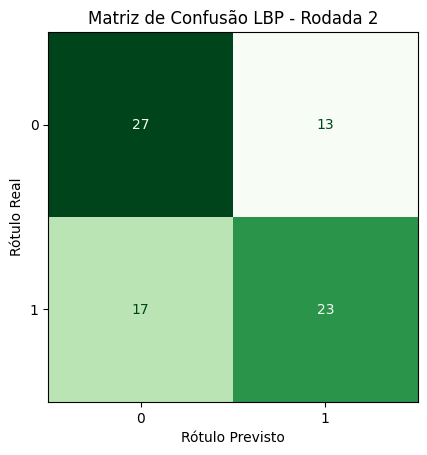

A acurácia no conjunto de testes: 62.50%
A recall no conjunto de testes: 62.50%
A precision no conjunto de testes: 62.63%
A F1 no conjunto de testes: 62.41%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.61      0.68      0.64        40
           1       0.64      0.57      0.61        40

    accuracy                           0.62        80
   macro avg       0.63      0.62      0.62        80
weighted avg       0.63      0.62      0.62        80



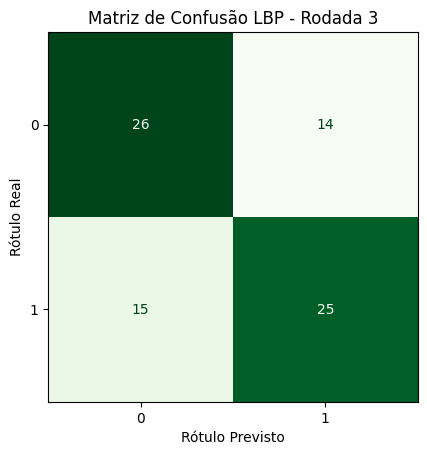

A acurácia no conjunto de testes: 63.75%
A recall no conjunto de testes: 63.75%
A precision no conjunto de testes: 63.76%
A F1 no conjunto de testes: 63.74%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.63      0.65      0.64        40
           1       0.64      0.62      0.63        40

    accuracy                           0.64        80
   macro avg       0.64      0.64      0.64        80
weighted avg       0.64      0.64      0.64        80



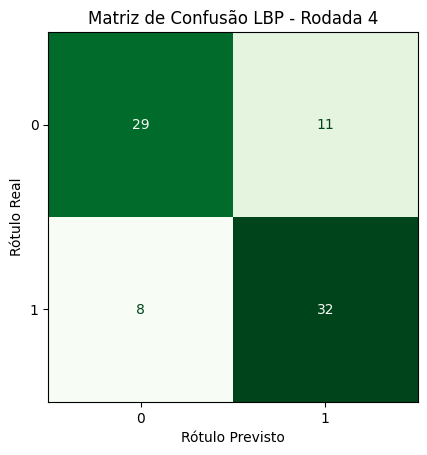

A acurácia no conjunto de testes: 76.25%
A recall no conjunto de testes: 76.25%
A precision no conjunto de testes: 76.40%
A F1 no conjunto de testes: 76.22%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        40
           1       0.74      0.80      0.77        40

    accuracy                           0.76        80
   macro avg       0.76      0.76      0.76        80
weighted avg       0.76      0.76      0.76        80



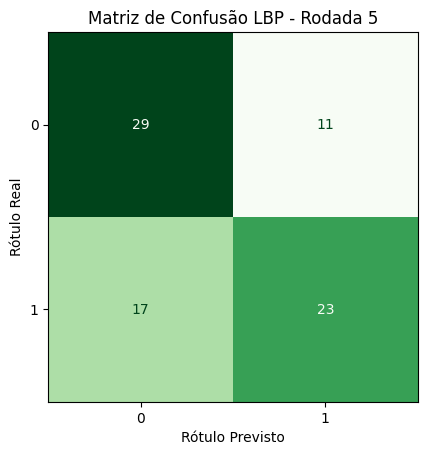

A acurácia no conjunto de testes: 65.00%
A recall no conjunto de testes: 65.00%
A precision no conjunto de testes: 65.35%
A F1 no conjunto de testes: 64.80%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.63      0.72      0.67        40
           1       0.68      0.57      0.62        40

    accuracy                           0.65        80
   macro avg       0.65      0.65      0.65        80
weighted avg       0.65      0.65      0.65        80

Avaliação do modelo LBP:
Acurácia: 0.65 +- 0.06
F1: 0.65 +- 0.06
Recall: 0.65 +- 0.06
Precisão: 0.65 +- 0.06


Classificação do conjunto GLCM:


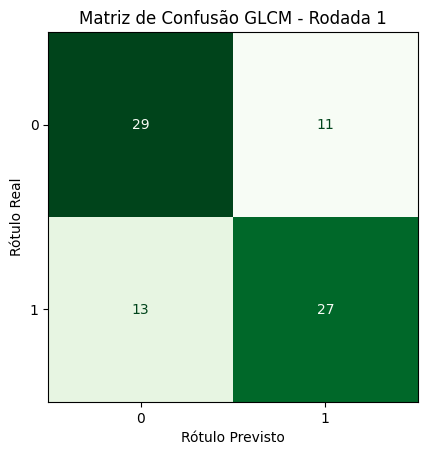

A acurácia no conjunto de testes: 70.00%
A recall no conjunto de testes: 70.00%
A precision no conjunto de testes: 70.05%
A F1 no conjunto de testes: 69.98%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.69      0.72      0.71        40
           1       0.71      0.68      0.69        40

    accuracy                           0.70        80
   macro avg       0.70      0.70      0.70        80
weighted avg       0.70      0.70      0.70        80



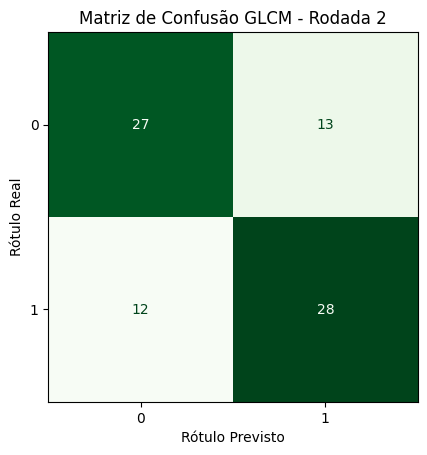

A acurácia no conjunto de testes: 68.75%
A recall no conjunto de testes: 68.75%
A precision no conjunto de testes: 68.76%
A F1 no conjunto de testes: 68.75%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.69      0.68      0.68        40
           1       0.68      0.70      0.69        40

    accuracy                           0.69        80
   macro avg       0.69      0.69      0.69        80
weighted avg       0.69      0.69      0.69        80



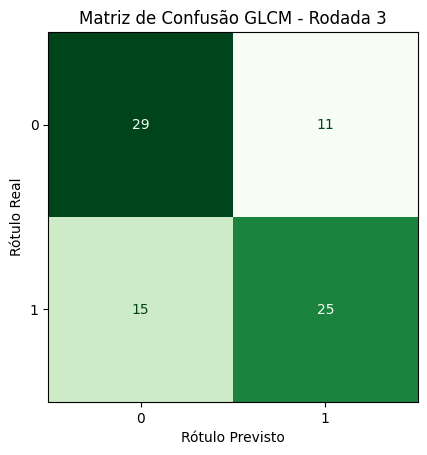

A acurácia no conjunto de testes: 67.50%
A recall no conjunto de testes: 67.50%
A precision no conjunto de testes: 67.68%
A F1 no conjunto de testes: 67.42%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.66      0.72      0.69        40
           1       0.69      0.62      0.66        40

    accuracy                           0.68        80
   macro avg       0.68      0.68      0.67        80
weighted avg       0.68      0.68      0.67        80



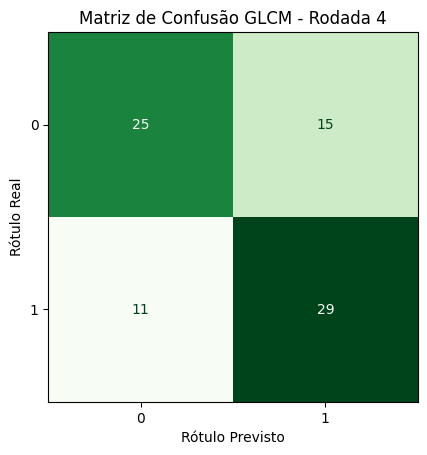

A acurácia no conjunto de testes: 67.50%
A recall no conjunto de testes: 67.50%
A precision no conjunto de testes: 67.68%
A F1 no conjunto de testes: 67.42%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.69      0.62      0.66        40
           1       0.66      0.72      0.69        40

    accuracy                           0.68        80
   macro avg       0.68      0.68      0.67        80
weighted avg       0.68      0.68      0.67        80



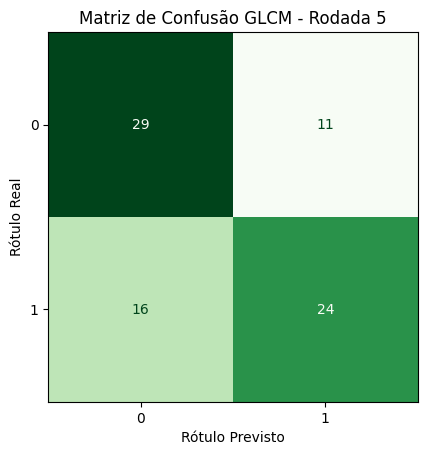

A acurácia no conjunto de testes: 66.25%
A recall no conjunto de testes: 66.25%
A precision no conjunto de testes: 66.51%
A F1 no conjunto de testes: 66.12%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.64      0.72      0.68        40
           1       0.69      0.60      0.64        40

    accuracy                           0.66        80
   macro avg       0.67      0.66      0.66        80
weighted avg       0.67      0.66      0.66        80

Avaliação do modelo GLCM:
Acurácia: 0.68 +- 0.01
F1: 0.68 +- 0.01
Recall: 0.68 +- 0.01
Precisão: 0.68 +- 0.01


Classificação do conjunto LPQ:


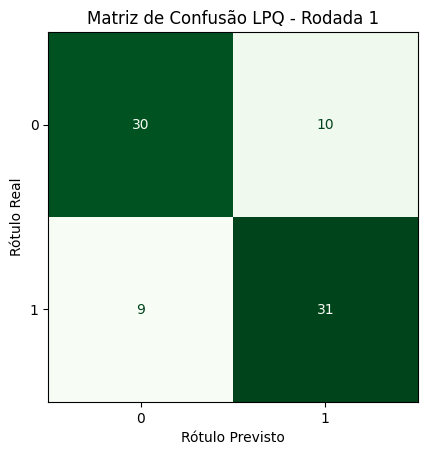

A acurácia no conjunto de testes: 76.25%
A recall no conjunto de testes: 76.25%
A precision no conjunto de testes: 76.27%
A F1 no conjunto de testes: 76.25%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.77      0.75      0.76        40
           1       0.76      0.78      0.77        40

    accuracy                           0.76        80
   macro avg       0.76      0.76      0.76        80
weighted avg       0.76      0.76      0.76        80



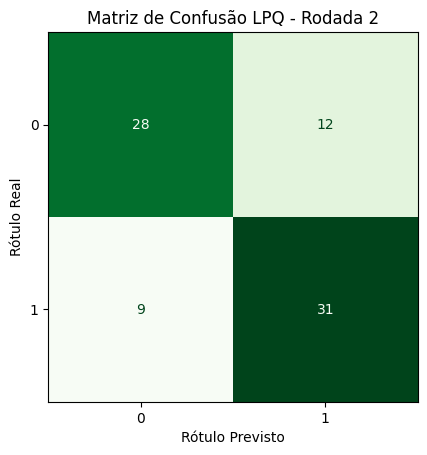

A acurácia no conjunto de testes: 73.75%
A recall no conjunto de testes: 73.75%
A precision no conjunto de testes: 73.88%
A F1 no conjunto de testes: 73.71%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        40
           1       0.72      0.78      0.75        40

    accuracy                           0.74        80
   macro avg       0.74      0.74      0.74        80
weighted avg       0.74      0.74      0.74        80



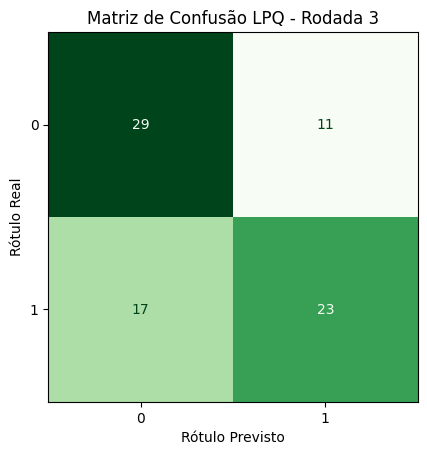

A acurácia no conjunto de testes: 65.00%
A recall no conjunto de testes: 65.00%
A precision no conjunto de testes: 65.35%
A F1 no conjunto de testes: 64.80%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.63      0.72      0.67        40
           1       0.68      0.57      0.62        40

    accuracy                           0.65        80
   macro avg       0.65      0.65      0.65        80
weighted avg       0.65      0.65      0.65        80



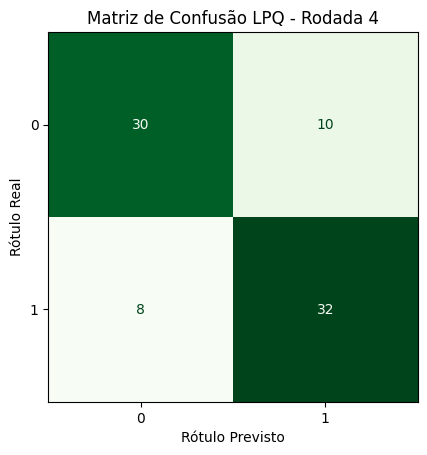

A acurácia no conjunto de testes: 77.50%
A recall no conjunto de testes: 77.50%
A precision no conjunto de testes: 77.57%
A F1 no conjunto de testes: 77.49%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.79      0.75      0.77        40
           1       0.76      0.80      0.78        40

    accuracy                           0.78        80
   macro avg       0.78      0.78      0.77        80
weighted avg       0.78      0.78      0.77        80



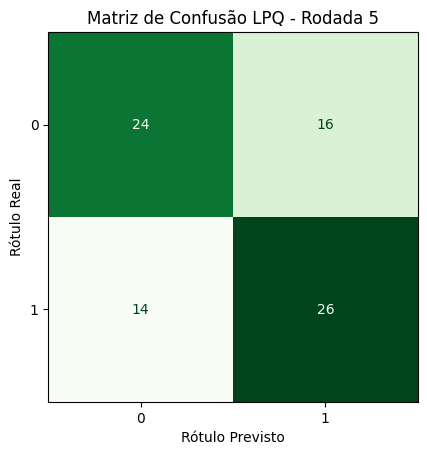

A acurácia no conjunto de testes: 62.50%
A recall no conjunto de testes: 62.50%
A precision no conjunto de testes: 62.53%
A F1 no conjunto de testes: 62.48%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.63      0.60      0.62        40
           1       0.62      0.65      0.63        40

    accuracy                           0.62        80
   macro avg       0.63      0.62      0.62        80
weighted avg       0.63      0.62      0.62        80

Avaliação do modelo LPQ:
Acurácia: 0.71 +- 0.06
F1: 0.71 +- 0.06
Recall: 0.71 +- 0.06
Precisão: 0.71 +- 0.06


Classificação do conjunto LBP+GLCM:


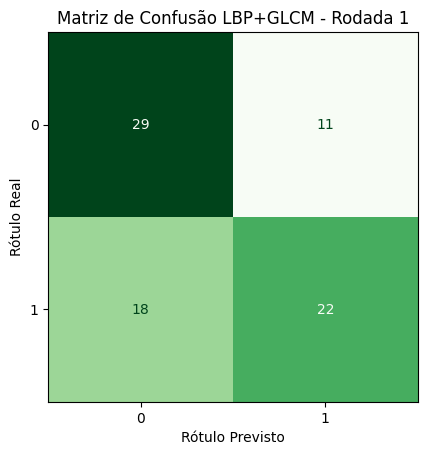

A acurácia no conjunto de testes: 63.75%
A recall no conjunto de testes: 63.75%
A precision no conjunto de testes: 64.18%
A F1 no conjunto de testes: 63.47%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        40
           1       0.67      0.55      0.60        40

    accuracy                           0.64        80
   macro avg       0.64      0.64      0.63        80
weighted avg       0.64      0.64      0.63        80



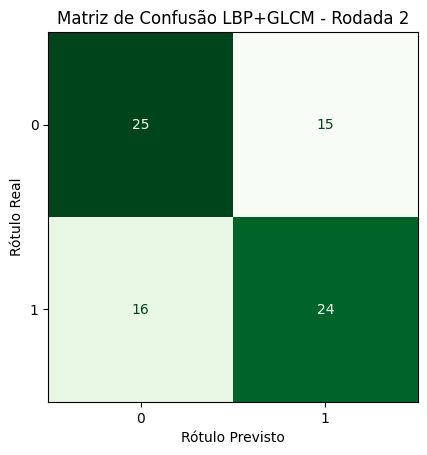

A acurácia no conjunto de testes: 61.25%
A recall no conjunto de testes: 61.25%
A precision no conjunto de testes: 61.26%
A F1 no conjunto de testes: 61.24%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.61      0.62      0.62        40
           1       0.62      0.60      0.61        40

    accuracy                           0.61        80
   macro avg       0.61      0.61      0.61        80
weighted avg       0.61      0.61      0.61        80



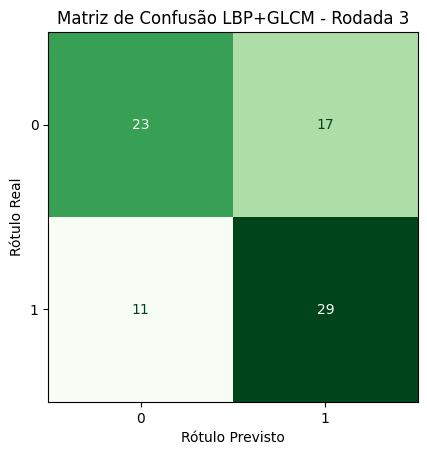

A acurácia no conjunto de testes: 65.00%
A recall no conjunto de testes: 65.00%
A precision no conjunto de testes: 65.35%
A F1 no conjunto de testes: 64.80%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.68      0.57      0.62        40
           1       0.63      0.72      0.67        40

    accuracy                           0.65        80
   macro avg       0.65      0.65      0.65        80
weighted avg       0.65      0.65      0.65        80



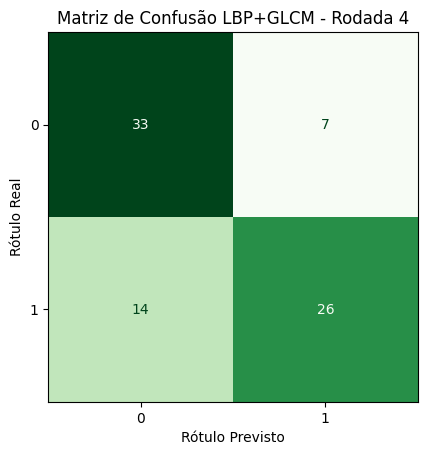

A acurácia no conjunto de testes: 73.75%
A recall no conjunto de testes: 73.75%
A precision no conjunto de testes: 74.50%
A F1 no conjunto de testes: 73.55%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.70      0.82      0.76        40
           1       0.79      0.65      0.71        40

    accuracy                           0.74        80
   macro avg       0.75      0.74      0.74        80
weighted avg       0.75      0.74      0.74        80



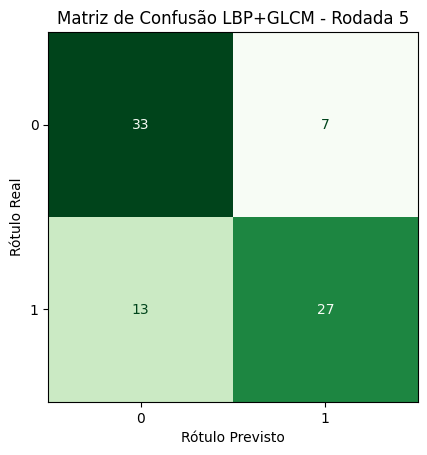

A acurácia no conjunto de testes: 75.00%
A recall no conjunto de testes: 75.00%
A precision no conjunto de testes: 75.58%
A F1 no conjunto de testes: 74.86%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.72      0.82      0.77        40
           1       0.79      0.68      0.73        40

    accuracy                           0.75        80
   macro avg       0.76      0.75      0.75        80
weighted avg       0.76      0.75      0.75        80

Avaliação do modelo LBP+GLCM:
Acurácia: 0.68 +- 0.06
F1: 0.68 +- 0.06
Recall: 0.68 +- 0.06
Precisão: 0.68 +- 0.06


Classificação do conjunto LBP+LPQ:


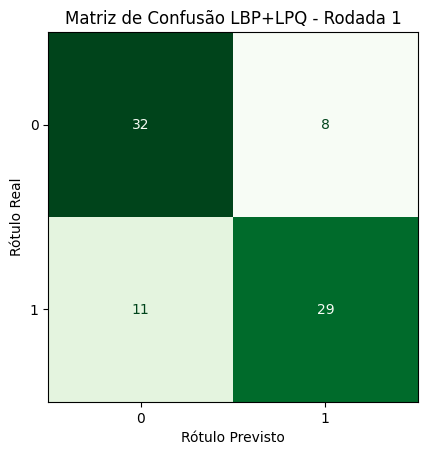

A acurácia no conjunto de testes: 76.25%
A recall no conjunto de testes: 76.25%
A precision no conjunto de testes: 76.40%
A F1 no conjunto de testes: 76.22%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.74      0.80      0.77        40
           1       0.78      0.72      0.75        40

    accuracy                           0.76        80
   macro avg       0.76      0.76      0.76        80
weighted avg       0.76      0.76      0.76        80



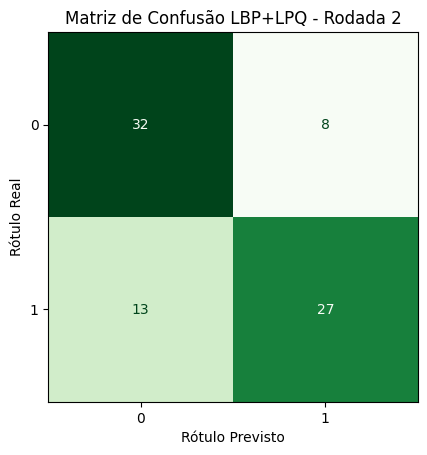

A acurácia no conjunto de testes: 73.75%
A recall no conjunto de testes: 73.75%
A precision no conjunto de testes: 74.13%
A F1 no conjunto de testes: 73.65%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        40
           1       0.77      0.68      0.72        40

    accuracy                           0.74        80
   macro avg       0.74      0.74      0.74        80
weighted avg       0.74      0.74      0.74        80



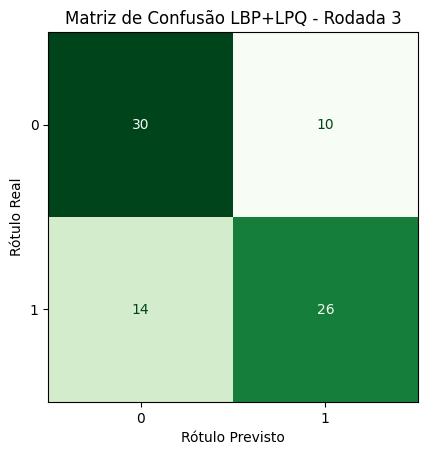

A acurácia no conjunto de testes: 70.00%
A recall no conjunto de testes: 70.00%
A precision no conjunto de testes: 70.20%
A F1 no conjunto de testes: 69.92%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.68      0.75      0.71        40
           1       0.72      0.65      0.68        40

    accuracy                           0.70        80
   macro avg       0.70      0.70      0.70        80
weighted avg       0.70      0.70      0.70        80



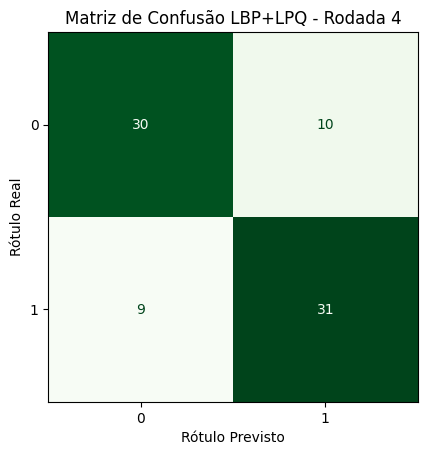

A acurácia no conjunto de testes: 76.25%
A recall no conjunto de testes: 76.25%
A precision no conjunto de testes: 76.27%
A F1 no conjunto de testes: 76.25%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.77      0.75      0.76        40
           1       0.76      0.78      0.77        40

    accuracy                           0.76        80
   macro avg       0.76      0.76      0.76        80
weighted avg       0.76      0.76      0.76        80



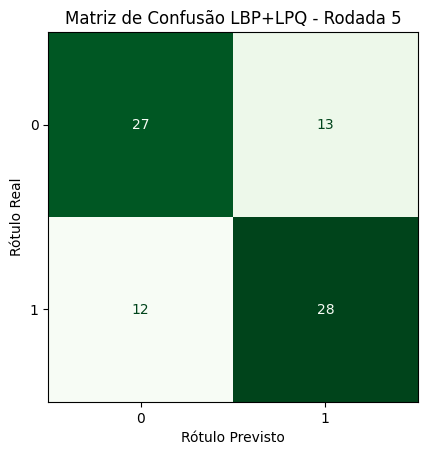

A acurácia no conjunto de testes: 68.75%
A recall no conjunto de testes: 68.75%
A precision no conjunto de testes: 68.76%
A F1 no conjunto de testes: 68.75%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.69      0.68      0.68        40
           1       0.68      0.70      0.69        40

    accuracy                           0.69        80
   macro avg       0.69      0.69      0.69        80
weighted avg       0.69      0.69      0.69        80

Avaliação do modelo LBP+LPQ:
Acurácia: 0.73 +- 0.03
F1: 0.73 +- 0.03
Recall: 0.73 +- 0.03
Precisão: 0.73 +- 0.03


Classificação do conjunto GLCM+LPQ:


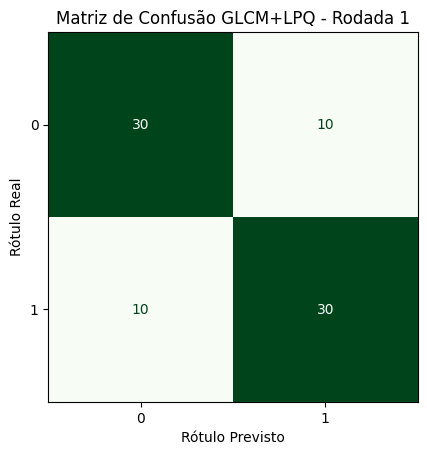

A acurácia no conjunto de testes: 75.00%
A recall no conjunto de testes: 75.00%
A precision no conjunto de testes: 75.00%
A F1 no conjunto de testes: 75.00%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        40
           1       0.75      0.75      0.75        40

    accuracy                           0.75        80
   macro avg       0.75      0.75      0.75        80
weighted avg       0.75      0.75      0.75        80



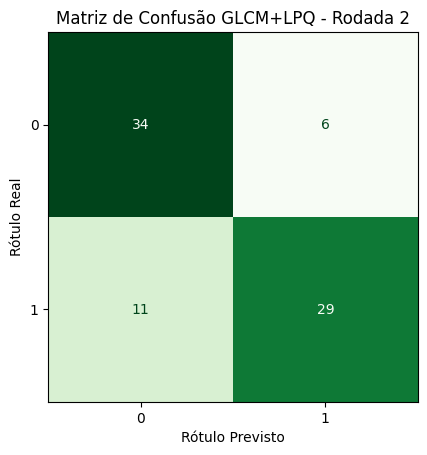

A acurácia no conjunto de testes: 78.75%
A recall no conjunto de testes: 78.75%
A precision no conjunto de testes: 79.21%
A F1 no conjunto de testes: 78.67%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        40
           1       0.83      0.72      0.77        40

    accuracy                           0.79        80
   macro avg       0.79      0.79      0.79        80
weighted avg       0.79      0.79      0.79        80



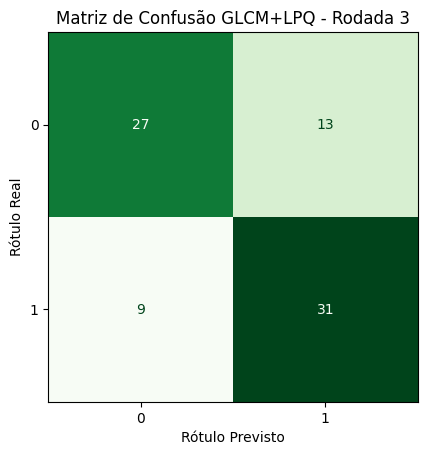

A acurácia no conjunto de testes: 72.50%
A recall no conjunto de testes: 72.50%
A precision no conjunto de testes: 72.73%
A F1 no conjunto de testes: 72.43%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.75      0.68      0.71        40
           1       0.70      0.78      0.74        40

    accuracy                           0.72        80
   macro avg       0.73      0.73      0.72        80
weighted avg       0.73      0.72      0.72        80



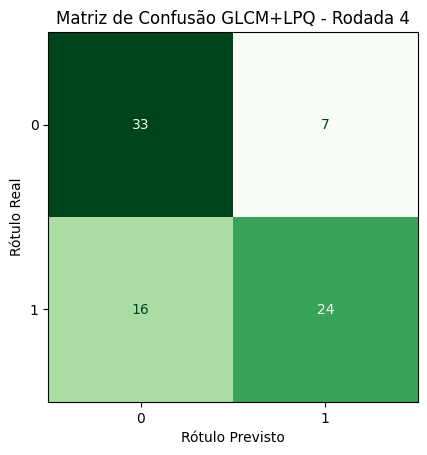

A acurácia no conjunto de testes: 71.25%
A recall no conjunto de testes: 71.25%
A precision no conjunto de testes: 72.38%
A F1 no conjunto de testes: 70.88%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.67      0.82      0.74        40
           1       0.77      0.60      0.68        40

    accuracy                           0.71        80
   macro avg       0.72      0.71      0.71        80
weighted avg       0.72      0.71      0.71        80



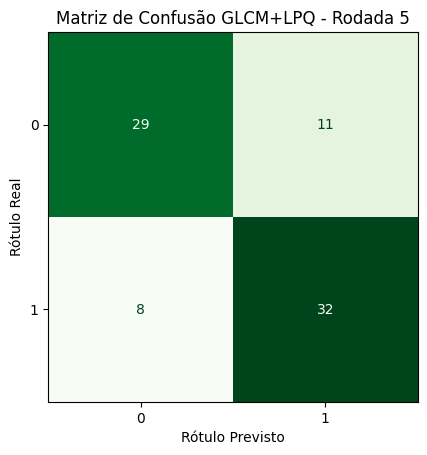

A acurácia no conjunto de testes: 76.25%
A recall no conjunto de testes: 76.25%
A precision no conjunto de testes: 76.40%
A F1 no conjunto de testes: 76.22%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        40
           1       0.74      0.80      0.77        40

    accuracy                           0.76        80
   macro avg       0.76      0.76      0.76        80
weighted avg       0.76      0.76      0.76        80

Avaliação do modelo GLCM+LPQ:
Acurácia: 0.75 +- 0.03
F1: 0.75 +- 0.03
Recall: 0.75 +- 0.03
Precisão: 0.75 +- 0.03


Classificação do conjunto LBP+GLCM+LPQ:


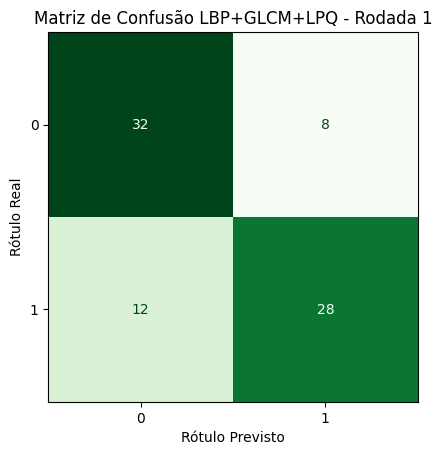

A acurácia no conjunto de testes: 75.00%
A recall no conjunto de testes: 75.00%
A precision no conjunto de testes: 75.25%
A F1 no conjunto de testes: 74.94%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        40
           1       0.78      0.70      0.74        40

    accuracy                           0.75        80
   macro avg       0.75      0.75      0.75        80
weighted avg       0.75      0.75      0.75        80



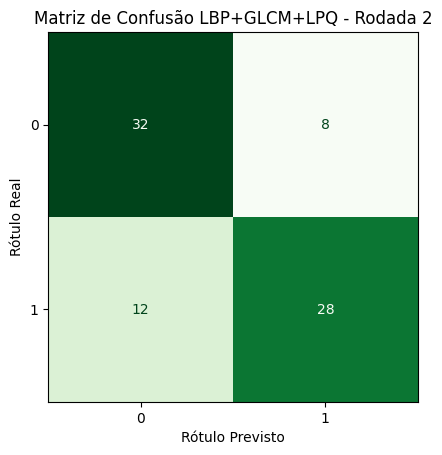

A acurácia no conjunto de testes: 75.00%
A recall no conjunto de testes: 75.00%
A precision no conjunto de testes: 75.25%
A F1 no conjunto de testes: 74.94%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        40
           1       0.78      0.70      0.74        40

    accuracy                           0.75        80
   macro avg       0.75      0.75      0.75        80
weighted avg       0.75      0.75      0.75        80



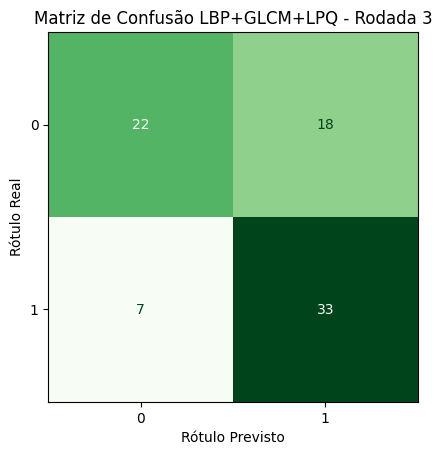

A acurácia no conjunto de testes: 68.75%
A recall no conjunto de testes: 68.75%
A precision no conjunto de testes: 70.28%
A F1 no conjunto de testes: 68.15%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.76      0.55      0.64        40
           1       0.65      0.82      0.73        40

    accuracy                           0.69        80
   macro avg       0.70      0.69      0.68        80
weighted avg       0.70      0.69      0.68        80



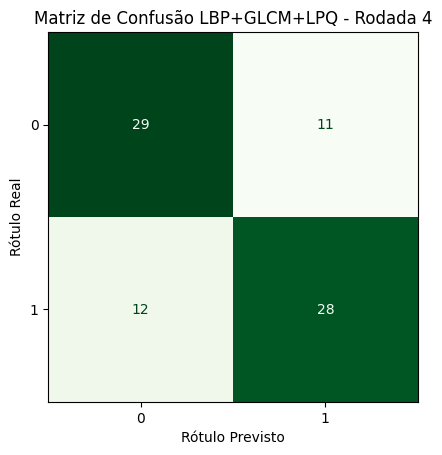

A acurácia no conjunto de testes: 71.25%
A recall no conjunto de testes: 71.25%
A precision no conjunto de testes: 71.26%
A F1 no conjunto de testes: 71.25%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        40
           1       0.72      0.70      0.71        40

    accuracy                           0.71        80
   macro avg       0.71      0.71      0.71        80
weighted avg       0.71      0.71      0.71        80



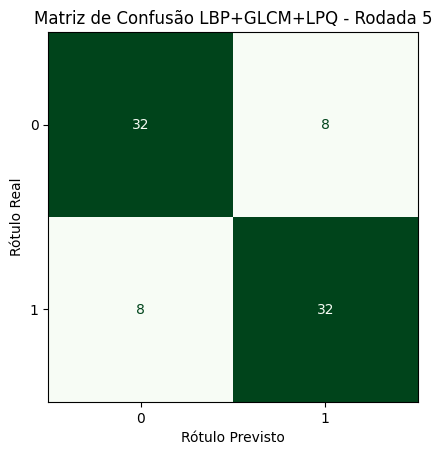

A acurácia no conjunto de testes: 80.00%
A recall no conjunto de testes: 80.00%
A precision no conjunto de testes: 80.00%
A F1 no conjunto de testes: 80.00%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        40
           1       0.80      0.80      0.80        40

    accuracy                           0.80        80
   macro avg       0.80      0.80      0.80        80
weighted avg       0.80      0.80      0.80        80

Avaliação do modelo LBP+GLCM+LPQ:
Acurácia: 0.74 +- 0.04
F1: 0.74 +- 0.04
Recall: 0.74 +- 0.04
Precisão: 0.74 +- 0.03




In [ ]:
# Classificando o conjunto de testes

best_dt = None

def predict_dt(dt, X, y, title=""):
    skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
    metrics = ([], [], [], [])
    rodada = 1
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dt.fit(X_train, y_train)

        predict = dt.predict(X_test)

        accuracy, f1, recall, precision = show_predict_infos(y_test, predict, title=f"{title} - Rodada {rodada}", cmap="Greens")

        metrics[0].append(accuracy)
        metrics[1].append(f1)
        metrics[2].append(recall)
        metrics[3].append(precision)
                          
        rodada+=1
    
    mean_accuracy, std_accuracy = np.mean(metrics[0]), np.std(metrics[0])
    mean_f1, std_f1 = np.mean(metrics[1]), np.std(metrics[1])
    mean_recall, std_recall = np.mean(metrics[2]), np.std(metrics[2])
    mean_precision, std_precision = np.mean(metrics[3]), np.std(metrics[3])
    
    print(f"Avaliação média do modelo {title}:")
    print("Acurácia: %.2f +- %.2f" % (mean_accuracy, std_accuracy))
    print("F1: %.2f +- %.2f" % (mean_f1, std_f1))
    print("Recall: %.2f +- %.2f" % (mean_recall, std_recall))
    print("Precisão: %.2f +- %.2f" % (mean_precision, std_precision))
    print("====================================\n\n")

    global best_dt
    if best_dt is None or mean_f1 > best_dt[2][0]:
        best_dt = (title, (mean_accuracy, std_accuracy), (mean_f1, std_f1), (mean_recall, std_recall), (mean_precision, std_precision))

print("Resultados Modelo Árvore de Decisão:")
print("Classificação do conjunto LBP:")
predict_dt(base_dt, set_lbp[0], set_lbp[1], title="LBP")

print("Classificação do conjunto GLCM:")
predict_dt(base_dt, set_glcm[0], set_glcm[1], title="GLCM")

print("Classificação do conjunto LPQ:")
predict_dt(base_dt, set_lpq[0], set_lpq[1], title="LPQ")

print("Classificação do conjunto LBP+GLCM:")
predict_dt(base_dt, set_lbp_glcm[0], set_lbp_glcm[1], title="LBP+GLCM")

print("Classificação do conjunto LBP+LPQ:")
predict_dt(base_dt, set_lbp_lpq[0], set_lbp_lpq[1], title="LBP+LPQ")

print("Classificação do conjunto GLCM+LPQ:")
predict_dt(base_dt, set_glcm_lpq[0], set_glcm_lpq[1], title="GLCM+LPQ")

print("Classificação do conjunto LBP+GLCM+LPQ:")
predict_dt(base_dt, set_lbp_glcm_lpq[0], set_lbp_glcm_lpq[1], title="LBP+GLCM+LPQ")

print(f"=== Melhor modelo DT: {best_dt[0]} ===")
print("Acurácia: %.3f +- %.3f}" % (best_dt[1][0], best_dt[1][1]))
print("F1: %.3f +- %.3f}" % (best_dt[2][0], best_dt[2][1]))
print("Recall: %.3f +- %.3f}" % (best_dt[3][0], best_dt[3][1]))
print("Precisão: %.3f +- %.3f}" % (best_dt[4][0], best_dt[4][1]))
print("<====================================>\n\n")

# SVM

In [24]:
# Importa as bibliotecas da SVM
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

import utils
from utils import show_predict_infos
importlib.reload(utils)

<module 'utils' from '/home/afmireski/Documentos/github/ai/images_classificator/utils.py'>

In [25]:
# Hiperparâmetros da SVM:
# Originais
# KERNELS = ['rbf', 'linear', 'poly', 'sigmoid']
# C = [0.1, 1, 10, 100, 1000]
# GAMMA = [2e-5, 2e-3, 2e-1, "auto", "scale"]
# DEGREE = [2, 3, 4, 5]
# COEF0 = [0, 0.1, 0.5, 1, 5, 10]

# Simplificado
KERNELS = ['rbf']
C = [0.1, 1, 10, 100, 1000]
GAMMA = [2e-5, 2e-3, 2e-1, "auto", "scale"]

In [26]:
def tune_svm(
    kernels,
    c_array,
    gamma_array,
    # degree_array,
    # coef0_array,
):
    svm = SVC()

    # Lista com as combinações de hiperparâmetros
    parameters = {
        "svm__kernel": kernels,
        "svm__C": c_array,
        "svm__gamma": gamma_array,
        # "svm__degree": degree_array,
        # "svm__coef0": coef0_array,
    }

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", svm)
    ])

    model = GridSearchCV(pipe, parameters, n_jobs=-1)


    return model

print("Tunando SVM...")
base_svm = tune_svm(
    KERNELS,
    C,
    GAMMA,
    # DEGREE,
    # COEF0,
)

Tunando SVM...


Resultados Modelo SVM:
Classificação do conjunto LBP:


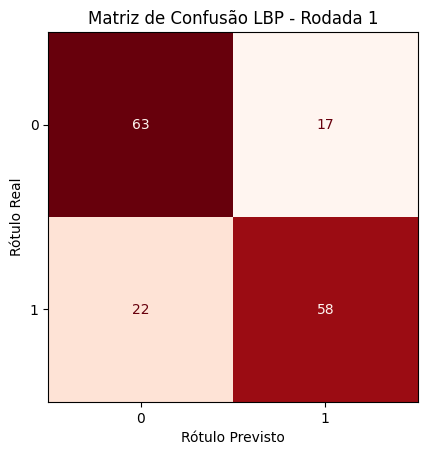

A acurácia no conjunto de testes: 75.62%
A recall no conjunto de testes: 75.62%
A precision no conjunto de testes: 75.73%
A F1 no conjunto de testes: 75.60%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.74      0.79      0.76        80
           1       0.77      0.72      0.75        80

    accuracy                           0.76       160
   macro avg       0.76      0.76      0.76       160
weighted avg       0.76      0.76      0.76       160



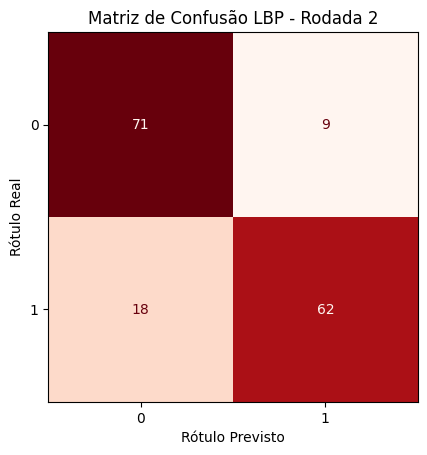

A acurácia no conjunto de testes: 83.12%
A recall no conjunto de testes: 83.12%
A precision no conjunto de testes: 83.55%
A F1 no conjunto de testes: 83.07%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        80
           1       0.87      0.78      0.82        80

    accuracy                           0.83       160
   macro avg       0.84      0.83      0.83       160
weighted avg       0.84      0.83      0.83       160



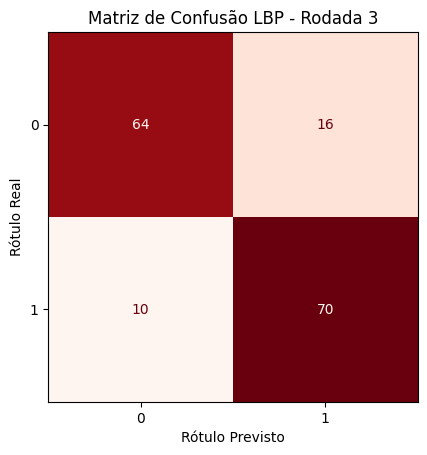

A acurácia no conjunto de testes: 83.75%
A recall no conjunto de testes: 83.75%
A precision no conjunto de testes: 83.94%
A F1 no conjunto de testes: 83.73%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        80
           1       0.81      0.88      0.84        80

    accuracy                           0.84       160
   macro avg       0.84      0.84      0.84       160
weighted avg       0.84      0.84      0.84       160



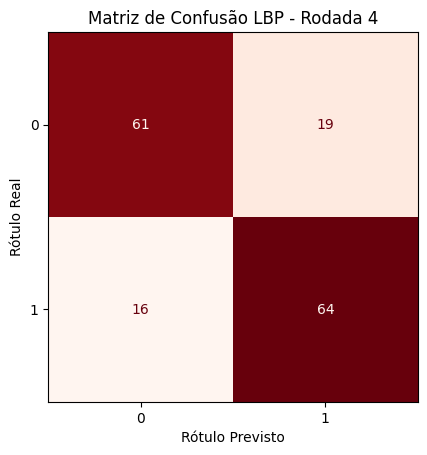

A acurácia no conjunto de testes: 78.12%
A recall no conjunto de testes: 78.12%
A precision no conjunto de testes: 78.16%
A F1 no conjunto de testes: 78.12%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.79      0.76      0.78        80
           1       0.77      0.80      0.79        80

    accuracy                           0.78       160
   macro avg       0.78      0.78      0.78       160
weighted avg       0.78      0.78      0.78       160



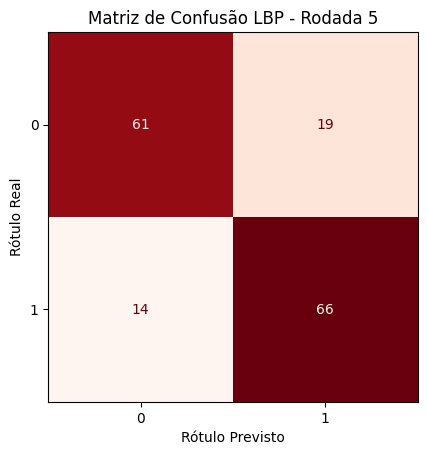

A acurácia no conjunto de testes: 79.38%
A recall no conjunto de testes: 79.38%
A precision no conjunto de testes: 79.49%
A F1 no conjunto de testes: 79.35%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.81      0.76      0.79        80
           1       0.78      0.82      0.80        80

    accuracy                           0.79       160
   macro avg       0.79      0.79      0.79       160
weighted avg       0.79      0.79      0.79       160

Avaliação média do modelo LBP:
Acurácia: 0.80 +- 0.03
F1: 0.80 +- 0.03
Recall: 0.80 +- 0.03
Precisão: 0.80 +- 0.03


Classificação do conjunto GLCM:


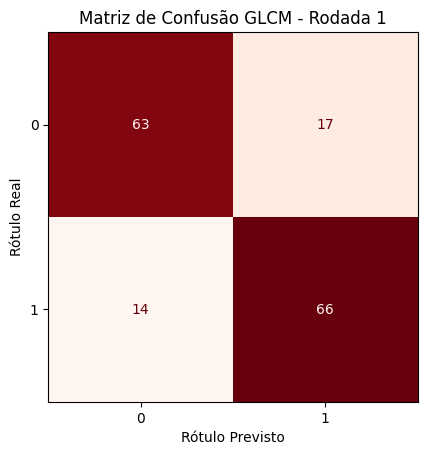

A acurácia no conjunto de testes: 80.62%
A recall no conjunto de testes: 80.62%
A precision no conjunto de testes: 80.67%
A F1 no conjunto de testes: 80.62%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.82      0.79      0.80        80
           1       0.80      0.82      0.81        80

    accuracy                           0.81       160
   macro avg       0.81      0.81      0.81       160
weighted avg       0.81      0.81      0.81       160



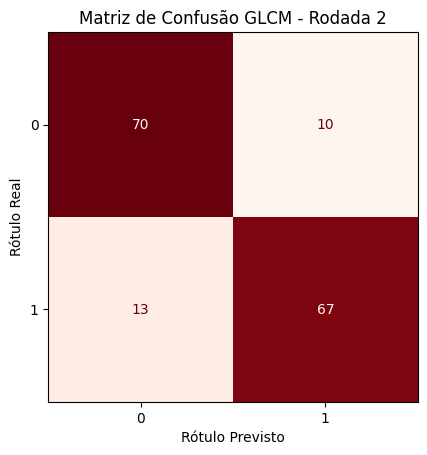

A acurácia no conjunto de testes: 85.62%
A recall no conjunto de testes: 85.62%
A precision no conjunto de testes: 85.68%
A F1 no conjunto de testes: 85.62%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        80
           1       0.87      0.84      0.85        80

    accuracy                           0.86       160
   macro avg       0.86      0.86      0.86       160
weighted avg       0.86      0.86      0.86       160



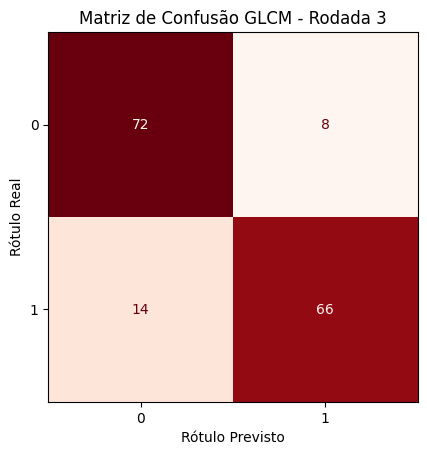

A acurácia no conjunto de testes: 86.25%
A recall no conjunto de testes: 86.25%
A precision no conjunto de testes: 86.46%
A F1 no conjunto de testes: 86.23%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        80
           1       0.89      0.82      0.86        80

    accuracy                           0.86       160
   macro avg       0.86      0.86      0.86       160
weighted avg       0.86      0.86      0.86       160



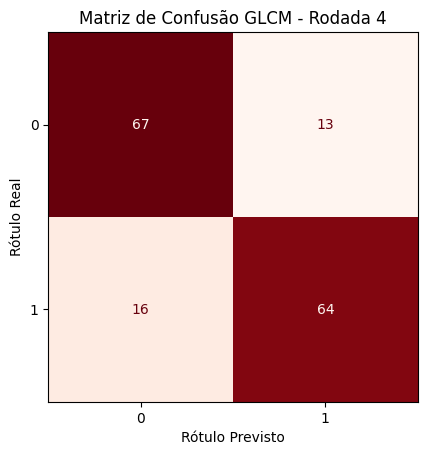

A acurácia no conjunto de testes: 81.88%
A recall no conjunto de testes: 81.88%
A precision no conjunto de testes: 81.92%
A F1 no conjunto de testes: 81.87%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.81      0.84      0.82        80
           1       0.83      0.80      0.82        80

    accuracy                           0.82       160
   macro avg       0.82      0.82      0.82       160
weighted avg       0.82      0.82      0.82       160



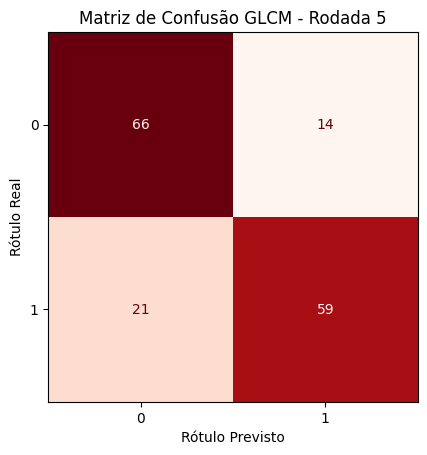

A acurácia no conjunto de testes: 78.12%
A recall no conjunto de testes: 78.12%
A precision no conjunto de testes: 78.34%
A F1 no conjunto de testes: 78.08%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.76      0.82      0.79        80
           1       0.81      0.74      0.77        80

    accuracy                           0.78       160
   macro avg       0.78      0.78      0.78       160
weighted avg       0.78      0.78      0.78       160

Avaliação média do modelo GLCM:
Acurácia: 0.82 +- 0.03
F1: 0.82 +- 0.03
Recall: 0.82 +- 0.03
Precisão: 0.83 +- 0.03


Classificação do conjunto LPQ:


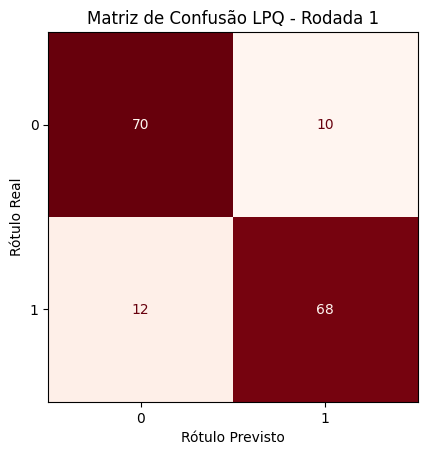

A acurácia no conjunto de testes: 86.25%
A recall no conjunto de testes: 86.25%
A precision no conjunto de testes: 86.27%
A F1 no conjunto de testes: 86.25%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        80
           1       0.87      0.85      0.86        80

    accuracy                           0.86       160
   macro avg       0.86      0.86      0.86       160
weighted avg       0.86      0.86      0.86       160



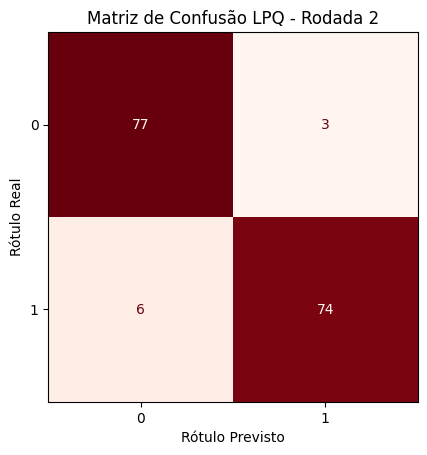

A acurácia no conjunto de testes: 94.38%
A recall no conjunto de testes: 94.38%
A precision no conjunto de testes: 94.44%
A F1 no conjunto de testes: 94.37%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.93      0.96      0.94        80
           1       0.96      0.93      0.94        80

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160



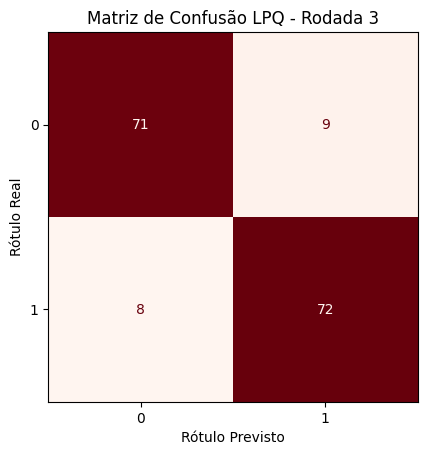

A acurácia no conjunto de testes: 89.38%
A recall no conjunto de testes: 89.38%
A precision no conjunto de testes: 89.38%
A F1 no conjunto de testes: 89.37%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.90      0.89      0.89        80
           1       0.89      0.90      0.89        80

    accuracy                           0.89       160
   macro avg       0.89      0.89      0.89       160
weighted avg       0.89      0.89      0.89       160



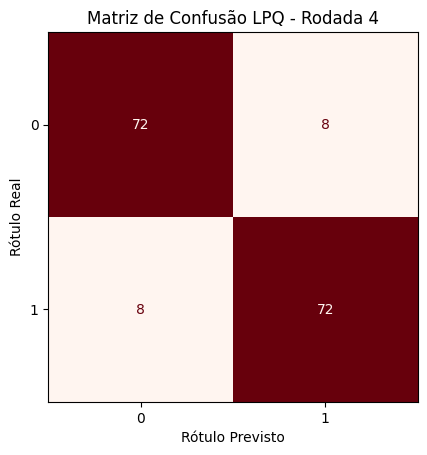

A acurácia no conjunto de testes: 90.00%
A recall no conjunto de testes: 90.00%
A precision no conjunto de testes: 90.00%
A F1 no conjunto de testes: 90.00%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        80
           1       0.90      0.90      0.90        80

    accuracy                           0.90       160
   macro avg       0.90      0.90      0.90       160
weighted avg       0.90      0.90      0.90       160



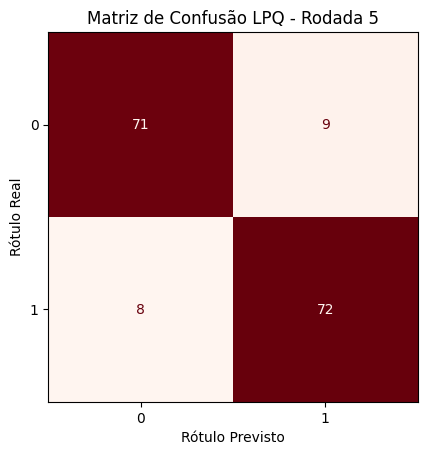

A acurácia no conjunto de testes: 89.38%
A recall no conjunto de testes: 89.38%
A precision no conjunto de testes: 89.38%
A F1 no conjunto de testes: 89.37%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.90      0.89      0.89        80
           1       0.89      0.90      0.89        80

    accuracy                           0.89       160
   macro avg       0.89      0.89      0.89       160
weighted avg       0.89      0.89      0.89       160

Avaliação média do modelo LPQ:
Acurácia: 0.90 +- 0.03
F1: 0.90 +- 0.03
Recall: 0.90 +- 0.03
Precisão: 0.90 +- 0.03


Classificação do conjunto LBP+GLCM:


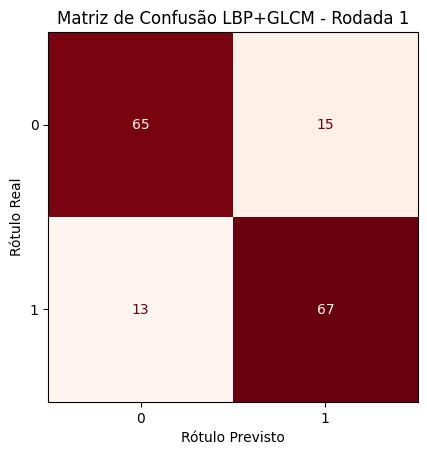

A acurácia no conjunto de testes: 82.50%
A recall no conjunto de testes: 82.50%
A precision no conjunto de testes: 82.52%
A F1 no conjunto de testes: 82.50%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        80
           1       0.82      0.84      0.83        80

    accuracy                           0.82       160
   macro avg       0.83      0.82      0.82       160
weighted avg       0.83      0.82      0.82       160



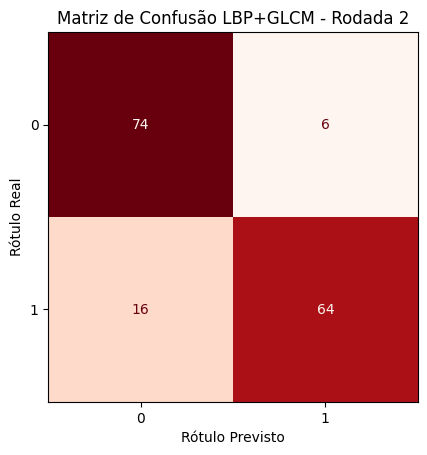

A acurácia no conjunto de testes: 86.25%
A recall no conjunto de testes: 86.25%
A precision no conjunto de testes: 86.83%
A F1 no conjunto de testes: 86.20%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        80
           1       0.91      0.80      0.85        80

    accuracy                           0.86       160
   macro avg       0.87      0.86      0.86       160
weighted avg       0.87      0.86      0.86       160



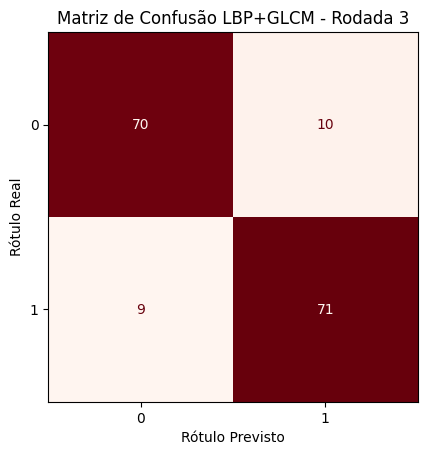

A acurácia no conjunto de testes: 88.12%
A recall no conjunto de testes: 88.12%
A precision no conjunto de testes: 88.13%
A F1 no conjunto de testes: 88.12%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.89      0.88      0.88        80
           1       0.88      0.89      0.88        80

    accuracy                           0.88       160
   macro avg       0.88      0.88      0.88       160
weighted avg       0.88      0.88      0.88       160



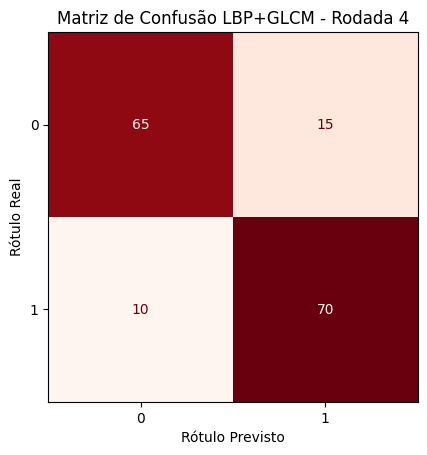

A acurácia no conjunto de testes: 84.38%
A recall no conjunto de testes: 84.38%
A precision no conjunto de testes: 84.51%
A F1 no conjunto de testes: 84.36%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.87      0.81      0.84        80
           1       0.82      0.88      0.85        80

    accuracy                           0.84       160
   macro avg       0.85      0.84      0.84       160
weighted avg       0.85      0.84      0.84       160



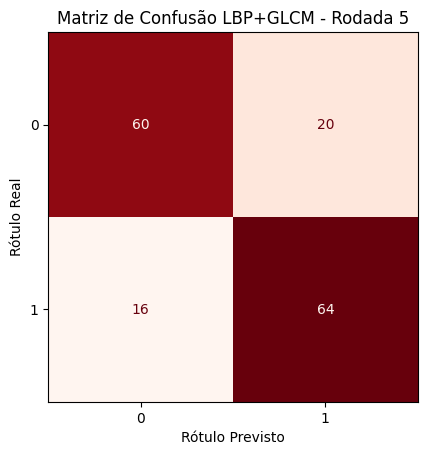

A acurácia no conjunto de testes: 77.50%
A recall no conjunto de testes: 77.50%
A precision no conjunto de testes: 77.57%
A F1 no conjunto de testes: 77.49%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.79      0.75      0.77        80
           1       0.76      0.80      0.78        80

    accuracy                           0.78       160
   macro avg       0.78      0.78      0.77       160
weighted avg       0.78      0.78      0.77       160

Avaliação média do modelo LBP+GLCM:
Acurácia: 0.84 +- 0.04
F1: 0.84 +- 0.04
Recall: 0.84 +- 0.04
Precisão: 0.84 +- 0.04


Classificação do conjunto LBP+LPQ:


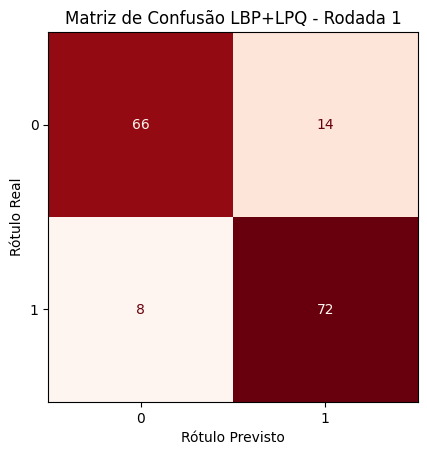

A acurácia no conjunto de testes: 86.25%
A recall no conjunto de testes: 86.25%
A precision no conjunto de testes: 86.46%
A F1 no conjunto de testes: 86.23%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.89      0.82      0.86        80
           1       0.84      0.90      0.87        80

    accuracy                           0.86       160
   macro avg       0.86      0.86      0.86       160
weighted avg       0.86      0.86      0.86       160



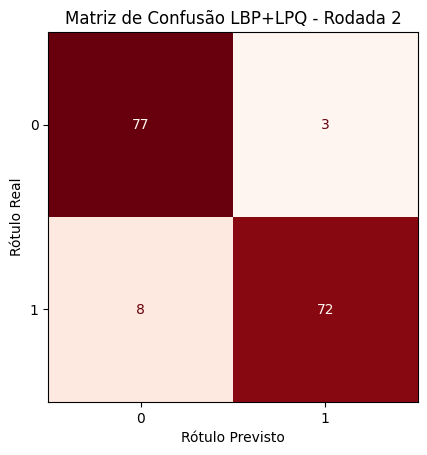

A acurácia no conjunto de testes: 93.12%
A recall no conjunto de testes: 93.12%
A precision no conjunto de testes: 93.29%
A F1 no conjunto de testes: 93.12%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        80
           1       0.96      0.90      0.93        80

    accuracy                           0.93       160
   macro avg       0.93      0.93      0.93       160
weighted avg       0.93      0.93      0.93       160



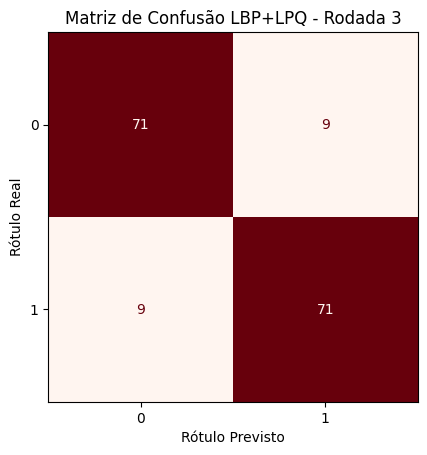

A acurácia no conjunto de testes: 88.75%
A recall no conjunto de testes: 88.75%
A precision no conjunto de testes: 88.75%
A F1 no conjunto de testes: 88.75%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        80
           1       0.89      0.89      0.89        80

    accuracy                           0.89       160
   macro avg       0.89      0.89      0.89       160
weighted avg       0.89      0.89      0.89       160



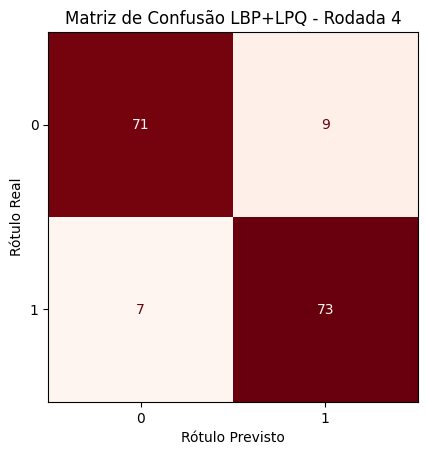

A acurácia no conjunto de testes: 90.00%
A recall no conjunto de testes: 90.00%
A precision no conjunto de testes: 90.03%
A F1 no conjunto de testes: 90.00%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        80
           1       0.89      0.91      0.90        80

    accuracy                           0.90       160
   macro avg       0.90      0.90      0.90       160
weighted avg       0.90      0.90      0.90       160



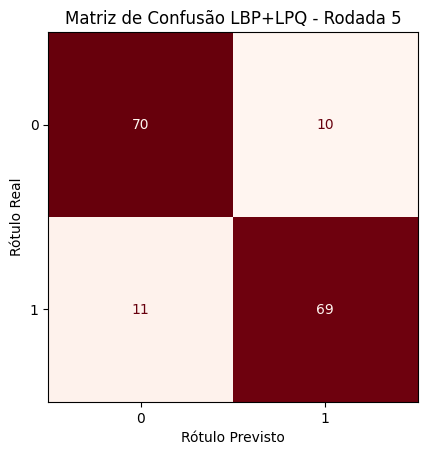

A acurácia no conjunto de testes: 86.88%
A recall no conjunto de testes: 86.88%
A precision no conjunto de testes: 86.88%
A F1 no conjunto de testes: 86.87%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        80
           1       0.87      0.86      0.87        80

    accuracy                           0.87       160
   macro avg       0.87      0.87      0.87       160
weighted avg       0.87      0.87      0.87       160

Avaliação média do modelo LBP+LPQ:
Acurácia: 0.89 +- 0.02
F1: 0.89 +- 0.02
Recall: 0.89 +- 0.02
Precisão: 0.89 +- 0.02


Classificação do conjunto GLCM+LPQ:


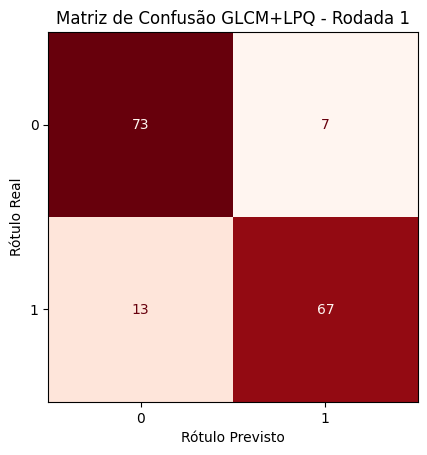

A acurácia no conjunto de testes: 87.50%
A recall no conjunto de testes: 87.50%
A precision no conjunto de testes: 87.71%
A F1 no conjunto de testes: 87.48%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        80
           1       0.91      0.84      0.87        80

    accuracy                           0.88       160
   macro avg       0.88      0.88      0.87       160
weighted avg       0.88      0.88      0.87       160



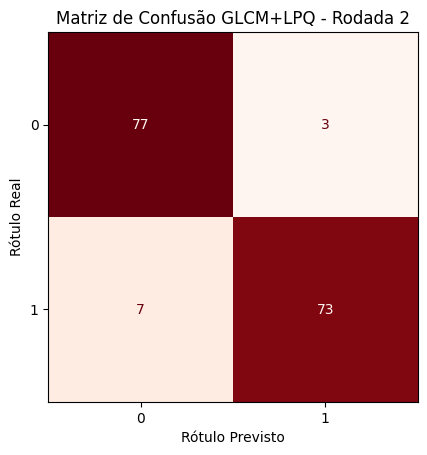

A acurácia no conjunto de testes: 93.75%
A recall no conjunto de testes: 93.75%
A precision no conjunto de testes: 93.86%
A F1 no conjunto de testes: 93.75%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        80
           1       0.96      0.91      0.94        80

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160



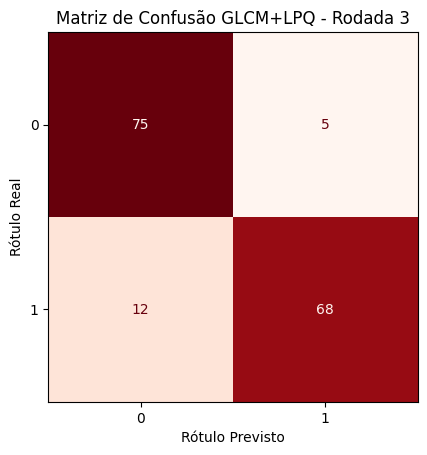

A acurácia no conjunto de testes: 89.38%
A recall no conjunto de testes: 89.38%
A precision no conjunto de testes: 89.68%
A F1 no conjunto de testes: 89.35%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        80
           1       0.93      0.85      0.89        80

    accuracy                           0.89       160
   macro avg       0.90      0.89      0.89       160
weighted avg       0.90      0.89      0.89       160



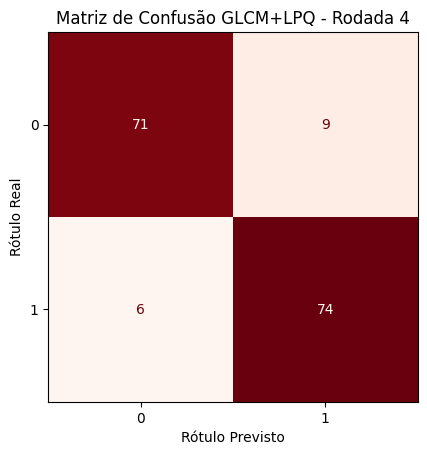

A acurácia no conjunto de testes: 90.62%
A recall no conjunto de testes: 90.62%
A precision no conjunto de testes: 90.68%
A F1 no conjunto de testes: 90.62%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.92      0.89      0.90        80
           1       0.89      0.93      0.91        80

    accuracy                           0.91       160
   macro avg       0.91      0.91      0.91       160
weighted avg       0.91      0.91      0.91       160



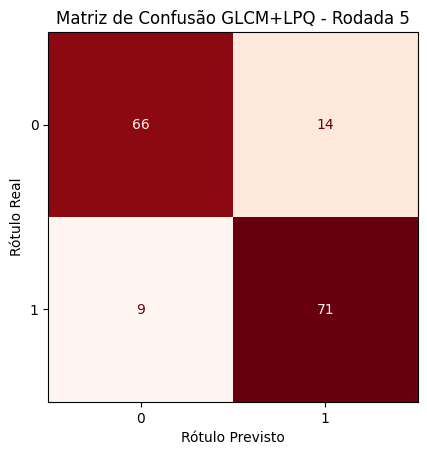

A acurácia no conjunto de testes: 85.62%
A recall no conjunto de testes: 85.62%
A precision no conjunto de testes: 85.76%
A F1 no conjunto de testes: 85.61%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        80
           1       0.84      0.89      0.86        80

    accuracy                           0.86       160
   macro avg       0.86      0.86      0.86       160
weighted avg       0.86      0.86      0.86       160

Avaliação média do modelo GLCM+LPQ:
Acurácia: 0.89 +- 0.03
F1: 0.89 +- 0.03
Recall: 0.89 +- 0.03
Precisão: 0.90 +- 0.03


Classificação do conjunto LBP+GLCM+LPQ:


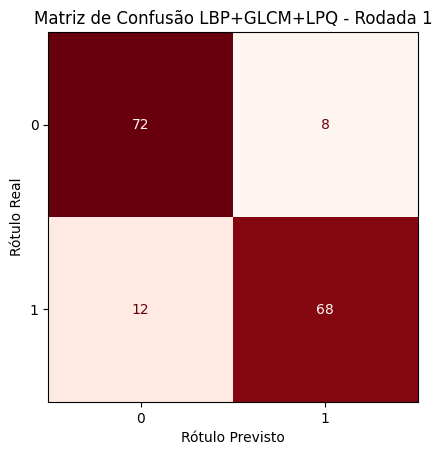

A acurácia no conjunto de testes: 87.50%
A recall no conjunto de testes: 87.50%
A precision no conjunto de testes: 87.59%
A F1 no conjunto de testes: 87.49%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        80
           1       0.89      0.85      0.87        80

    accuracy                           0.88       160
   macro avg       0.88      0.88      0.87       160
weighted avg       0.88      0.88      0.87       160



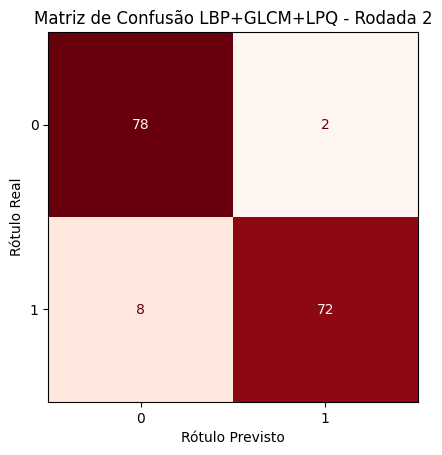

A acurácia no conjunto de testes: 93.75%
A recall no conjunto de testes: 93.75%
A precision no conjunto de testes: 94.00%
A F1 no conjunto de testes: 93.74%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        80
           1       0.97      0.90      0.94        80

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160



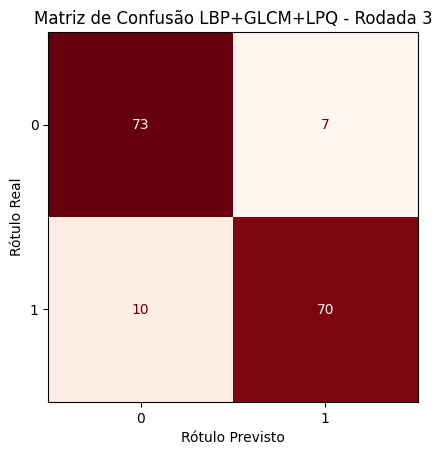

A acurácia no conjunto de testes: 89.38%
A recall no conjunto de testes: 89.38%
A precision no conjunto de testes: 89.43%
A F1 no conjunto de testes: 89.37%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.88      0.91      0.90        80
           1       0.91      0.88      0.89        80

    accuracy                           0.89       160
   macro avg       0.89      0.89      0.89       160
weighted avg       0.89      0.89      0.89       160



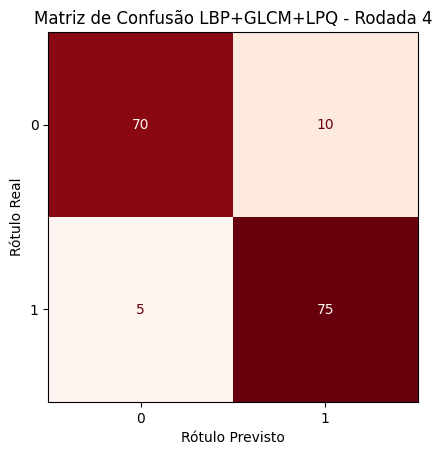

A acurácia no conjunto de testes: 90.62%
A recall no conjunto de testes: 90.62%
A precision no conjunto de testes: 90.78%
A F1 no conjunto de testes: 90.62%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        80
           1       0.88      0.94      0.91        80

    accuracy                           0.91       160
   macro avg       0.91      0.91      0.91       160
weighted avg       0.91      0.91      0.91       160



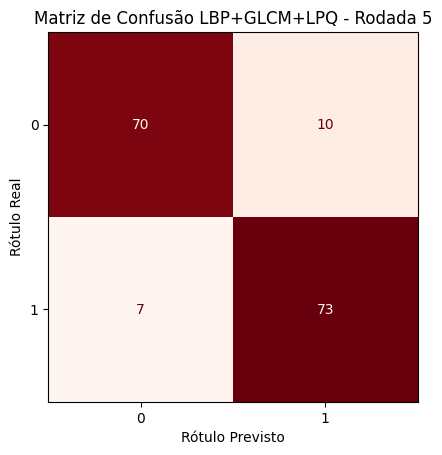

A acurácia no conjunto de testes: 89.38%
A recall no conjunto de testes: 89.38%
A precision no conjunto de testes: 89.43%
A F1 no conjunto de testes: 89.37%

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.91      0.88      0.89        80
           1       0.88      0.91      0.90        80

    accuracy                           0.89       160
   macro avg       0.89      0.89      0.89       160
weighted avg       0.89      0.89      0.89       160

Avaliação média do modelo LBP+GLCM+LPQ:
Acurácia: 0.90 +- 0.02
F1: 0.90 +- 0.02
Recall: 0.90 +- 0.02
Precisão: 0.90 +- 0.02


=== Melhor modelo SVM: LBP+GLCM+LPQ ===
Acurácia: 0.901 +- 0.021}
F1: 0.901 +- 0.021}
Recall: 0.901 +- 0.021}
Precisão: 0.902 +- 0.021}
<====================================>




In [27]:
# Classificando o conjunto de testes

best_svm = None

def predict_svm(svm, X, y, title=""):
    skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
    metrics = ([], [], [], [])
    rodada = 1
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        svm.fit(X_train, y_train)

        predict = svm.predict(X_test)

        accuracy, f1, recall, precision = show_predict_infos(y_test, predict, title=f"{title} - Rodada {rodada}", cmap="Reds")

        metrics[0].append(accuracy)
        metrics[1].append(f1)
        metrics[2].append(recall)
        metrics[3].append(precision)
                          
        rodada+=1
    
    mean_accuracy, std_accuracy = np.mean(metrics[0]), np.std(metrics[0])
    mean_f1, std_f1 = np.mean(metrics[1]), np.std(metrics[1])
    mean_recall, std_recall = np.mean(metrics[2]), np.std(metrics[2])
    mean_precision, std_precision = np.mean(metrics[3]), np.std(metrics[3])
    
    print(f"Avaliação média do modelo {title}:")
    print("Acurácia: %.2f +- %.2f" % (mean_accuracy, std_accuracy))
    print("F1: %.2f +- %.2f" % (mean_f1, std_f1))
    print("Recall: %.2f +- %.2f" % (mean_recall, std_recall))
    print("Precisão: %.2f +- %.2f" % (mean_precision, std_precision))
    print("====================================\n\n")

    global best_svm
    if best_svm is None or mean_f1 > best_svm[2][0]:
        best_svm = (title, (mean_accuracy, std_accuracy), (mean_f1, std_f1), (mean_recall, std_recall), (mean_precision, std_precision))

print("Resultados Modelo SVM:")
print("Classificação do conjunto LBP:")
predict_svm(base_svm, set_lbp[0], set_lbp[1], title="LBP")

print("Classificação do conjunto GLCM:")
predict_svm(base_svm, set_glcm[0], set_glcm[1], title="GLCM")

print("Classificação do conjunto LPQ:")
predict_svm(base_svm, set_lpq[0], set_lpq[1], title="LPQ")

print("Classificação do conjunto LBP+GLCM:")
predict_svm(base_svm, set_lbp_glcm[0], set_lbp_glcm[1], title="LBP+GLCM")

print("Classificação do conjunto LBP+LPQ:")
predict_svm(base_svm, set_lbp_lpq[0], set_lbp_lpq[1], title="LBP+LPQ")

print("Classificação do conjunto GLCM+LPQ:")
predict_svm(base_svm, set_glcm_lpq[0], set_glcm_lpq[1], title="GLCM+LPQ")

print("Classificação do conjunto LBP+GLCM+LPQ:")
predict_svm(base_svm, set_lbp_glcm_lpq[0], set_lbp_glcm_lpq[1], title="LBP+GLCM+LPQ")

print(f"=== Melhor modelo SVM: {best_svm[0]} ===")
print("Acurácia: %.3f +- %.3f}" % (best_svm[1][0], best_svm[1][1]))
print("F1: %.3f +- %.3f}" % (best_svm[2][0], best_svm[2][1]))
print("Recall: %.3f +- %.3f}" % (best_svm[3][0], best_svm[3][1]))
print("Precisão: %.3f +- %.3f}" % (best_svm[4][0], best_svm[4][1]))
print("<====================================>\n\n")